In [1]:
import h5py

In [17]:
with h5py.File('../../scripts/data/killms_datapack_2.hdf5') as f, h5py.File('../../scripts/data/killms_datapack_3.hdf5') as g:
    g['/sol000/tec000/val'][...] = f['/sol000/tec000/val'][...]
    g['/sol000/tec000/weight'][...] = f['/sol000/tec000/weight'][...]

In [12]:
from bayes_tec.bayes_opt.maximum_likelihood_tec import solve_ml_tec
from bayes_tec.datapack import DataPack
import numpy as np

In [14]:
with DataPack('../../scripts/data/killms_datapack_4.hdf5',readonly=False) as datapack:#'/home/albert/git/IonoTomo/src/ionotomo/data/NsolutionsDDE_2.5Jy_tecandphasePF_correctedlosoto_fulltime_dec27.h5',readonly=True) as datapack:
    datapack.switch_solset('sol000')
    datapack.select(ant="RS*",pol=slice(0,1,1))
    amp, _ = datapack.amplitude

2018-11-01 16:01:28,740 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-01 16:01:28,753 Closing table.
2018-11-01 16:01:28,756 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-01 16:01:30,708 Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.
2018-11-01 16:01:30,727 Closing table.


In [18]:
import pylab as plt
plt.plot(amp[0,0,13,0,:])
plt.show()

In [47]:
Npol,Nd, Na,Nf,Nt = phase.shape
# tec = tec_.reshape((Npol,Nd,Na,Nt))
# sigma = sigma_.reshape((Npol, Nd, Na, Nt))

def wrap(phi):
    return np.angle(np.exp(1j*phi))

# phase_pred = -8.448e9*tec[...,None,:]/freqs[:,None]
# res = (wrap(wrap(phase) - wrap(phase_pred)))
res = tec - tec_ml

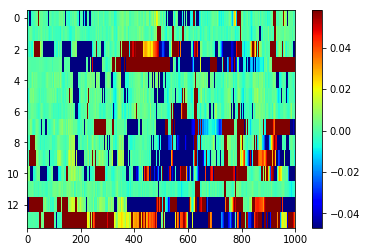

In [48]:
import numpy as np
import pylab as plt

import mpl_toolkits.mplot3d.axes3d as p3







# for l in range(Nt):
    
#     z = phase_pred[0,0,51,:,l]
#     x = times[l].mjd*np.ones(Nf)
#     y = freqs
# #     ax.scatter(x,y,z,c=plt.cm.jet(l/30),marker='+',alpha=0.5)
#     ax.plot(x,y,z,c='k',alpha=0.5)
#     ax.set_xlabel('times (mjd)')
#     ax.set_ylabel('frequency Hz')
#     ax.set_zlabel('phase (rad)')
# #     ax.set_zlim3d([-np.pi,np.pi])

# norm = plt.Normalize(res[0,0,51,:,:].min(),res[0,0,51,:,:].max())
norm = plt.Normalize(np.percentile(res,10),np.percentile(res,90))

c = plt.cm.jet(norm(res[0,0,:,:]))
plt.imshow(res[0,0,:,:], cmap=plt.cm.jet,norm=norm,aspect='auto')
plt.colorbar()
plt.show()

# fig = plt.figure(figsize=(12,12))
# ax = p3.Axes3D(fig)

    
# for l in range(Nf):
#     z = res[0,0,51,l,:]
#     x = times.mjd
#     y = freqs[l]*np.ones(Nt)
#     ax.plot(x,y,z,c='k',marker='+',alpha=0.9)
#     c = plt.cm.jet(norm(z))    
#     ax.scatter(x,y,z,c=c,alpha=0.5)
    
#     ax.set_xlabel('times (mjd)')
#     ax.set_ylabel('frequency Hz')
#     ax.set_zlabel('phase (rad)')
#     ax.set_zlim3d([-np.pi,np.pi])
# plt.show()
# plt.hist(res.flatten(),bins=100)
# plt.show()

In [1]:
from bayes_tec.datapack import DataPack
import numpy as np
import pylab as plt
plt.style.use('ggplot')
import os
        
def plot_solution_residuals(datapack, output_folder, data_solset='sol000', solution_solset='posterior_sol', 
                          ant_sel=None,time_sel=None,dir_sel=None,freq_sel=None,pol_sel=None):
    def _wrap(phi):
        return np.angle(np.exp(1j*phi))
    
    if not isinstance(datapack,str):
        datapack = datapack.filename

    output_folder = os.path.abspath(output_folder)
    os.makedirs(output_folder,exist_ok=True)

    solsets = [data_solset, solution_solset]
    with DataPack(datapack,readonly=True) as datapack:
        datapack.switch_solset(data_solset)
        datapack.select(ant=ant_sel,time=time_sel,dir=dir_sel,freq=freq_sel,pol=pol_sel)
        
        phase,axes = datapack.phase
        timestamps,times = datapack.get_times(axes['time'])
        antenna_labels, antennas = datapack.get_antennas(axes['ant'])
        patch_names, directions = datapack.get_sources(axes['dir'])
        _,freqs = datapack.get_freqs(axes['freq'])
        pols, _ = datapack.get_pols(axes['pol'])
        Npol,Nd,Na,Nf,Nt = phase.shape

        datapack.switch_solset(solution_solset)
        datapack.select(ant=ant_sel,time=time_sel,dir=dir_sel,freq=freq_sel,pol=pol_sel)
        tec,_ = datapack.tec
        phase_pred = -8.448e9*tec[...,None,:]/freqs[:,None]
        
        res = _wrap(_wrap(phase) - _wrap(phase_pred))
        cbar = None  
                
        for p in range(Npol):
            for a in range(Na):
                
                M = int(np.ceil(np.sqrt(Nd)))
                fig,axs = plt.subplots(nrows=2*M,ncols=M,sharex=True,figsize=(M*4,1*M*4),gridspec_kw = {'height_ratios':[1.5,1]*M})
                fig.subplots_adjust(wspace=0., hspace=0.)
                fig.subplots_adjust(right=0.85)
                cbar_ax = fig.add_axes([0.875, 0.15, 0.025, 0.7])
                
                vmin = -1.
                vmax = 1.
                norm = plt.Normalize(vmin, vmax)
                
                for row in range(0,2*M,2):
                    for col in range(M):
                        ax1 = axs[row][col]
                        ax2 = axs[row+1][col]
                        
                        d = col + row//2*M
                        if d >= Nd:
                            continue

                        img = ax1.imshow(res[p,d,a,:,:],origin='lower',aspect='auto',
                                  extent=(times[0].mjd*86400.,times[-1].mjd*86400.,freqs[0],freqs[-1]),
                                 cmap=plt.cm.jet, norm = norm)
                        ax1.text(0.05, 0.95, axes['dir'][d], horizontalalignment='left',verticalalignment='top', transform=ax1.transAxes,backgroundcolor=(1.,1.,1., 0.5))
                    
                        ax1.set_ylabel('frequency [Hz]')
                        ax1.legend()
                    

                        mean = res[p,d,a,:,:].mean(0)
                        ax2.plot(times.mjd*86400, mean,label=r'$\mathbb{E}_\nu[\delta\phi]$')
                        std = res[p,d,a,:,:].std(0)
                        ax2.fill_between(times.mjd*86400, mean - std, mean + std,alpha=0.5,label=r'$\pm\sigma_{\delta\phi}$')
                        ax2.set_xlabel('Time [mjs]')
                        ax2.set_xlim(times[0].mjd*86400.,times[-1].mjd*86400.)
                        ax2.set_ylim(-np.pi,np.pi)
#                         ax2.legend()
                        
                    
                fig.colorbar(img, cax=cbar_ax, orientation='vertical', label='phase dev. [rad]')
                filename = "{}_v_{}_{}_{}.png".format(data_solset,solution_solset, axes['ant'][a], axes['pol'][p])
                plt.savefig(os.path.join(output_folder,filename))
                plt.close('all')
                    
#                     plt.show()
        

In [2]:
plot_solution_residuals('../../scripts/data/killms_datapack_2.hdf5','output_folder_sol000',solution_solset='sol000',ant_sel='RS*',time_sel=slice(1,1000,1),pol_sel=slice(0,1,1),dir_sel=slice(0,None,1))

2018-10-01 11:34:04,183 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_2.hdf5.
2018-10-01 11:34:04,199 Closing table.
2018-10-01 11:34:04,202 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_2.hdf5.
2018-10-01 11:37:11,393 Closing table.


In [1]:
from bayes_tec.plotting.plot_datapack import animate_datapack

2018-10-30 23:33:28,949 CACHEDIR=/home/albert/.cache/matplotlib
2018-10-30 23:33:28,958 Using fontManager instance from /home/albert/.cache/matplotlib/fontlist-v300.json
2018-10-30 23:33:29,270 Loaded backend agg version unknown.


In [28]:
animate_datapack('../../scripts/data/killms_datapack_4.hdf5',
                 'figs_spec_13_facet_std',
                 num_processes=32,
                 ant_sel='RS*',
                 time_sel=slice(0,432,1),
                 observable='weights_tec', 
#                  tec_eval_freq=140e6, 
                 plot_facet_idx=True, 
                 labels_in_radec=True, 
                 plot_screen=False,
                 solset='posterior_sol_gains',
                 phase_wrap=True)

2018-11-06 17:50:55,768 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,776 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,783 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,778 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,785 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,785 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,788 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,792 Closing table.
2018-11-06 17:50:55,788 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,795 Appending to /net/lofar1/data1/al

2018-11-06 17:50:55,863 Closing table.
2018-11-06 17:50:55,863 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,864 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,864 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,864 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,864 Closing table.
2018-11-06 17:50:55,866 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,866 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,867 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,868 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:5

   4.98795934e+09],freq=None,dir=None,pol=None2018-11-06 17:50:55,920 turning off display
2018-11-06 17:50:55,920 Applying selection: ant=RS*,time=[  4.98795615e+09   4.98795641e+09   4.98795667e+09   4.98795692e+09
   4.98795718e+09   4.98795743e+09   4.98795769e+09   4.98795795e+09
   4.98795820e+09   4.98795846e+09   4.98795871e+09   4.98795897e+09
   4.98795922e+09   4.98795948e+09],freq=None,dir=None,pol=None2018-11-06 17:50:55,920 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-06 17:50:55,920 turning off display
2018-11-06 17:50:55,923 turning off display

2018-11-06 17:50:55,924 turning off display
2018-11-06 17:50:55,922 Applying selection: ant=RS*,time=[  4.98795615e+09   4.98795640e+09   4.98795666e+09   4.98795691e+09
   4.98795717e+09   4.98795743e+09   4.98795768e+09   4.98795794e+09
   4.98795819e+09   4.98795845e+09   4.98795870e+09   4.98795896e+09
   4.98795922e+09   4.98795947e+09],freq=None,dir=None,pol=None2018-11-06

   4.98795914e+09   4.98795939e+09],freq=None,dir=None,pol=None
2018-11-06 17:50:55,951 Applying selection: ant=RS*,time=[  4.98795619e+09   4.98795644e+09   4.98795670e+09   4.98795695e+09
   4.98795721e+09   4.98795747e+09   4.98795772e+09   4.98795798e+09
   4.98795823e+09   4.98795849e+09   4.98795874e+09   4.98795900e+09
   4.98795926e+09],freq=None,dir=None,pol=None


2018-11-06 17:50:56,024 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61], [27, 59, 91, 123, 155, 187, 219, 251, 283, 315, 347, 379, 411]]
2018-11-06 17:50:56,025 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61], [3, 35, 67, 99, 131, 163, 195, 227, 259, 291, 323, 355, 387, 419]]
2018-11-06 17:50:56,027 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61], [1, 33

2018-11-06 17:50:56,292 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [0], [31, 63, 95, 127, 159, 191, 223, 255, 287, 319, 351, 383, 415]]
2018-11-06 17:50:56,302 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [0], [20, 52, 84, 116, 148, 180, 212, 244, 276, 308, 340, 372, 404]]
2018-11-06 17:50:56,308 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [0], [3, 35, 67, 99, 131, 163, 195, 227, 259, 291, 323, 355, 387, 419]]
2018-11-06 17:50:56,316 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [0], [0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416]]
2018-11-06 17:50:56,306 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [0], [23, 55, 87, 119, 151, 183, 215, 247, 279, 311, 343, 375, 407]]
2018-11-06 17:50:56,323 Closing table.
2018-11-06 17:50:56,330 Optimizing selection reading [slice(None, None, None), slice(None,

2018-11-06 17:50:56,536 Plotting 14 antennas
2018-11-06 17:50:56,540 Closing table.
2018-11-06 17:50:56,544 Closing table.
2018-11-06 17:50:56,547 Plotting 45 directions
2018-11-06 17:50:56,546 Plotting 45 directions
2018-11-06 17:50:56,548 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [0], [21, 53, 85, 117, 149, 181, 213, 245, 277, 309, 341, 373, 405]]
2018-11-06 17:50:56,553 Plotting 14 antennas
2018-11-06 17:50:56,558 Closing table.
2018-11-06 17:50:56,565 Plotting 14 timestamps
2018-11-06 17:50:56,564 Plotting 45 directions
2018-11-06 17:50:56,567 Plotting 45 directions
2018-11-06 17:50:56,569 Closing table.
2018-11-06 17:50:56,568 Plotting 14 antennas
2018-11-06 17:50:56,571 Plotting 13 timestamps
2018-11-06 17:50:56,572 Plotting 45 directions
2018-11-06 17:50:56,575 Plotting 14 antennas
2018-11-06 17:50:56,577 Plotting 14 timestamps
2018-11-06 17:50:56,584 Plotting 14 antennas
2018-11-06 17:50:56,590 Plotting 14 timestamps
2018-11-06 17:50:56,589

2018-11-06 17:51:03,031 update_title_pos
2018-11-06 17:51:03,042 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-06 17:51:03,069 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-06 17:51:03,074 update_title_pos
2018-11-06 17:51:03,087 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py

2018-11-06 17:51:03,378 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-06 17:51:03,386 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f018f5cf208>
2018-11-06 17:51:03,385 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-06 17:51:03,390 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/

2018-11-06 17:51:03,577 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-06 17:51:03,573 update_title_pos
2018-11-06 17:51:03,593 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-06 17:51:03,587 update_title_pos
2018-11-06 17:51:03,595 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_

2018-11-06 17:51:03,724 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f018f5cb358>
2018-11-06 17:51:03,744 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-06 17:51:03,745 update_title_pos
2018-11-06 17:51:03,748 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-06 17:51:03,759 update_title_pos
2018-11-06 17:51:03,751 Setting pcolormesh
2018-11-06 17:51:03,763 update_title_pos
2018-11-06 17:51:03,737 Plotting 2016-12-08T23:21:53.00

2018-11-06 17:51:04,029 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-06 17:51:04,038 update_title_pos
2018-11-06 17:51:04,025 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f018f5ca898>
2018-11-06 17:51:04,045 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f018f5c9be0>
2018-11-06 17:51:04,051 update_title_pos
2018-11-06 17:51:04,060 update_title_pos
2018-11-06 17:51:04,060 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.05000

2018-11-06 17:51:04,430 update_title_pos
2018-11-06 17:51:04,434 update_title_pos
2018-11-06 17:51:04,437 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-06 17:51:04,447 update_title_pos
2018-11-06 17:51:04,425 update_title_pos
2018-11-06 17:51:04,462 update_title_pos
2018-11-06 17:51:04,452 update_title_pos
2018-11-06 17:51:04,481 update_title_pos
2018-11-06 17:51:04,490 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-06 17:51:04,504 update_title_pos
2018-11-

2018-11-06 17:51:05,501 update_title_pos
2018-11-06 17:51:05,529 update_title_pos
2018-11-06 17:51:05,530 update_title_pos
2018-11-06 17:51:05,503 update_title_pos
2018-11-06 17:51:05,537 update_title_pos
2018-11-06 17:51:05,538 update_title_pos
2018-11-06 17:51:05,544 update_title_pos
2018-11-06 17:51:05,545 update_title_pos
2018-11-06 17:51:05,566 update_title_pos
2018-11-06 17:51:05,557 update_title_pos
2018-11-06 17:51:05,574 update_title_pos
2018-11-06 17:51:05,580 update_title_pos
2018-11-06 17:51:05,613 update_title_pos
2018-11-06 17:51:05,613 update_title_pos
2018-11-06 17:51:05,643 update_title_pos
2018-11-06 17:51:05,619 update_title_pos
2018-11-06 17:51:05,648 update_title_pos
2018-11-06 17:51:05,650 update_title_pos
2018-11-06 17:51:05,657 update_title_pos
2018-11-06 17:51:05,652 update_title_pos
2018-11-06 17:51:05,654 update_title_pos
2018-11-06 17:51:05,669 update_title_pos
2018-11-06 17:51:05,687 update_title_pos
2018-11-06 17:51:05,683 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:06,958 update_title_pos
2018-11-06 17:51:06,959 update_title_pos
2018-11-06 17:51:06,963 update_title_pos
2018-11-06 17:51:06,967 update_title_pos
2018-11-06 17:51:06,971 update_title_pos
2018-11-06 17:51:06,975 update_title_pos
2018-11-06 17:51:06,972 update_title_pos
2018-11-06 17:51:06,983 update_title_pos
2018-11-06 17:51:06,987 update_title_pos
2018-11-06 17:51:06,992 update_title_pos
2018-11-06 17:51:06,998 update_title_pos
2018-11-06 17:51:06,992 update_title_pos
2018-11-06 17:51:07,005 update_title_pos
2018-11-06 17:51:07,006 update_title_pos
2018-11-06 17:51:07,021 update_title_pos
2018-11-06 17:51:07,021 update_title_pos
2018-11-06 17:51:07,025 update_title_pos
2018-11-06 17:51:07,030 update_title_pos
2018-11-06 17:51:07,029 update_title_pos
2018-11-06 17:51:07,027 update_title_pos
2018-11-06 17:51:07,033 update_title_pos
2018-11-06 17:51:07,039 update_title_pos
2018-11-06 17:51:07,039 update_title_pos
2018-11-06 17:51:07,042 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:07,870 update_title_pos
2018-11-06 17:51:07,882 update_title_pos
2018-11-06 17:51:07,883 update_title_pos
2018-11-06 17:51:07,861 update_title_pos
2018-11-06 17:51:07,887 update_title_pos
2018-11-06 17:51:07,896 update_title_pos
2018-11-06 17:51:07,904 update_title_pos
2018-11-06 17:51:07,913 update_title_pos
2018-11-06 17:51:07,919 update_title_pos
2018-11-06 17:51:07,920 update_title_pos
2018-11-06 17:51:07,924 update_title_pos
2018-11-06 17:51:07,929 update_title_pos
2018-11-06 17:51:07,933 update_title_pos
2018-11-06 17:51:07,961 update_title_pos
2018-11-06 17:51:07,977 update_title_pos
2018-11-06 17:51:07,978 update_title_pos
2018-11-06 17:51:07,979 update_title_pos
2018-11-06 17:51:07,982 update_title_pos
2018-11-06 17:51:07,983 update_title_pos
2018-11-06 17:51:07,980 update_title_pos
2018-11-06 17:51:07,990 update_title_pos
2018-11-06 17:51:08,000 update_title_pos
2018-11-06 17:51:08,012 update_title_pos
2018-11-06 17:51:08,020 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:09,057 update_title_pos
2018-11-06 17:51:09,036 update_title_pos
2018-11-06 17:51:09,072 update_title_pos
2018-11-06 17:51:09,074 update_title_pos
2018-11-06 17:51:09,054 update_title_pos
2018-11-06 17:51:09,086 update_title_pos
2018-11-06 17:51:09,071 update_title_pos
2018-11-06 17:51:09,089 update_title_pos
2018-11-06 17:51:09,113 update_title_pos
2018-11-06 17:51:09,115 update_title_pos
2018-11-06 17:51:09,130 update_title_pos
2018-11-06 17:51:09,139 update_title_pos
2018-11-06 17:51:09,144 update_title_pos
2018-11-06 17:51:09,153 update_title_pos
2018-11-06 17:51:09,159 update_title_pos
2018-11-06 17:51:09,166 update_title_pos
2018-11-06 17:51:09,175 update_title_pos
2018-11-06 17:51:09,172 update_title_pos
2018-11-06 17:51:09,163 update_title_pos
2018-11-06 17:51:09,184 update_title_pos
2018-11-06 17:51:09,199 update_title_pos
2018-11-06 17:51:09,202 update_title_pos
2018-11-06 17:51:09,211 update_title_pos
2018-11-06 17:51:09,218 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:10,606 update_title_pos
2018-11-06 17:51:10,636 update_title_pos
2018-11-06 17:51:10,684 update_title_pos
2018-11-06 17:51:10,693 update_title_pos
2018-11-06 17:51:10,691 update_title_pos
2018-11-06 17:51:10,728 update_title_pos
2018-11-06 17:51:10,771 update_title_pos
2018-11-06 17:51:10,804 update_title_pos
2018-11-06 17:51:10,822 update_title_pos
2018-11-06 17:51:10,831 update_title_pos
2018-11-06 17:51:10,811 update_title_pos
2018-11-06 17:51:10,849 update_title_pos
2018-11-06 17:51:10,914 update_title_pos
2018-11-06 17:51:10,896 update_title_pos
2018-11-06 17:51:10,956 update_title_pos
2018-11-06 17:51:11,002 update_title_pos
2018-11-06 17:51:11,016 update_title_pos
2018-11-06 17:51:11,021 update_title_pos
2018-11-06 17:51:11,016 update_title_pos
2018-11-06 17:51:11,033 update_title_pos
2018-11-06 17:51:11,035 update_title_pos
2018-11-06 17:51:11,041 update_title_pos
2018-11-06 17:51:11,056 update_title_pos
2018-11-06 17:51:11,067 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:12,457 update_title_pos
2018-11-06 17:51:12,465 update_title_pos
2018-11-06 17:51:12,470 update_title_pos
2018-11-06 17:51:12,487 update_title_pos
2018-11-06 17:51:12,516 update_title_pos
2018-11-06 17:51:12,513 update_title_pos
2018-11-06 17:51:12,524 update_title_pos
2018-11-06 17:51:12,512 update_title_pos
2018-11-06 17:51:12,530 update_title_pos
2018-11-06 17:51:12,535 update_title_pos
2018-11-06 17:51:12,523 update_title_pos
2018-11-06 17:51:12,549 update_title_pos
2018-11-06 17:51:12,558 update_title_pos
2018-11-06 17:51:12,542 update_title_pos
2018-11-06 17:51:12,569 update_title_pos
2018-11-06 17:51:12,574 update_title_pos
2018-11-06 17:51:12,574 update_title_pos
2018-11-06 17:51:12,578 update_title_pos
2018-11-06 17:51:12,578 update_title_pos
2018-11-06 17:51:12,600 update_title_pos
2018-11-06 17:51:12,624 update_title_pos
2018-11-06 17:51:12,627 update_title_pos
2018-11-06 17:51:12,639 update_title_pos
2018-11-06 17:51:12,631 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:13,657 update_title_pos
2018-11-06 17:51:13,669 update_title_pos
2018-11-06 17:51:13,680 update_title_pos
2018-11-06 17:51:13,687 update_title_pos
2018-11-06 17:51:13,682 update_title_pos
2018-11-06 17:51:13,686 update_title_pos
2018-11-06 17:51:13,649 update_title_pos
2018-11-06 17:51:13,701 update_title_pos
2018-11-06 17:51:13,700 update_title_pos
2018-11-06 17:51:13,692 update_title_pos
2018-11-06 17:51:13,703 update_title_pos
2018-11-06 17:51:13,713 update_title_pos
2018-11-06 17:51:13,711 update_title_pos
2018-11-06 17:51:13,685 update_title_pos
2018-11-06 17:51:13,719 update_title_pos
2018-11-06 17:51:13,721 update_title_pos
2018-11-06 17:51:13,725 update_title_pos
2018-11-06 17:51:13,738 update_title_pos
2018-11-06 17:51:13,737 update_title_pos
2018-11-06 17:51:13,739 update_title_pos
2018-11-06 17:51:13,747 update_title_pos
2018-11-06 17:51:13,757 update_title_pos
2018-11-06 17:51:13,756 update_title_pos
2018-11-06 17:51:13,760 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:14,533 update_title_pos
2018-11-06 17:51:14,529 Plotting 2016-12-08T23:25:37.005
2018-11-06 17:51:14,543 update_title_pos
2018-11-06 17:51:14,539 Plotting 2016-12-08T23:26:41.005
2018-11-06 17:51:14,556 update_title_pos
2018-11-06 17:51:14,557 update_title_pos
2018-11-06 17:51:14,555 Plotting 2016-12-08T23:26:49.005
2018-11-06 17:51:14,562 update_title_pos
2018-11-06 17:51:14,564 update_title_pos
2018-11-06 17:51:14,524 update_title_pos
2018-11-06 17:51:14,581 update_title_pos
2018-11-06 17:51:14,584 update_title_pos
2018-11-06 17:51:14,584 update_title_pos
2018-11-06 17:51:14,567 update_title_pos
2018-11-06 17:51:14,574 update_title_pos
2018-11-06 17:51:14,586 update_title_pos
2018-11-06 17:51:14,590 Plotting 2016-12-08T23:28:49.004
2018-11-06 17:51:14,605 update_title_pos
2018-11-06 17:51:14,603 update_title_pos
2018-11-06 17:51:14,620 update_title_pos
2018-11-06 17:51:14,621 update_title_pos
2018-11-06 17:51:14,599 update_title_pos
2018-11-06 17:51:14,619 Plotting 2

2018-11-06 17:51:15,573 update_title_pos
2018-11-06 17:51:15,574 update_title_pos
2018-11-06 17:51:15,577 update_title_pos
2018-11-06 17:51:15,579 update_title_pos
2018-11-06 17:51:15,588 update_title_pos
2018-11-06 17:51:15,597 update_title_pos
2018-11-06 17:51:15,599 update_title_pos
2018-11-06 17:51:15,604 update_title_pos
2018-11-06 17:51:15,615 update_title_pos
2018-11-06 17:51:15,616 update_title_pos
2018-11-06 17:51:15,616 update_title_pos
2018-11-06 17:51:15,609 update_title_pos
2018-11-06 17:51:15,621 update_title_pos
2018-11-06 17:51:15,626 update_title_pos
2018-11-06 17:51:15,619 update_title_pos
2018-11-06 17:51:15,630 update_title_pos
2018-11-06 17:51:15,631 update_title_pos
2018-11-06 17:51:15,643 update_title_pos
2018-11-06 17:51:15,651 update_title_pos
2018-11-06 17:51:15,656 update_title_pos
2018-11-06 17:51:15,659 update_title_pos
2018-11-06 17:51:15,662 update_title_pos
2018-11-06 17:51:15,647 update_title_pos
2018-11-06 17:51:15,666 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:16,707 update_title_pos
2018-11-06 17:51:16,716 update_title_pos
2018-11-06 17:51:16,711 update_title_pos
2018-11-06 17:51:16,724 update_title_pos
2018-11-06 17:51:16,711 update_title_pos
2018-11-06 17:51:16,723 update_title_pos
2018-11-06 17:51:16,737 update_title_pos
2018-11-06 17:51:16,744 update_title_pos
2018-11-06 17:51:16,751 update_title_pos
2018-11-06 17:51:16,753 update_title_pos
2018-11-06 17:51:16,761 update_title_pos
2018-11-06 17:51:16,774 update_title_pos
2018-11-06 17:51:16,776 update_title_pos
2018-11-06 17:51:16,781 update_title_pos
2018-11-06 17:51:16,790 update_title_pos
2018-11-06 17:51:16,794 update_title_pos
2018-11-06 17:51:16,799 update_title_pos
2018-11-06 17:51:16,804 update_title_pos
2018-11-06 17:51:16,806 update_title_pos
2018-11-06 17:51:16,806 update_title_pos
2018-11-06 17:51:16,796 update_title_pos
2018-11-06 17:51:16,819 update_title_pos
2018-11-06 17:51:16,824 update_title_pos
2018-11-06 17:51:16,828 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:17,727 update_title_pos
2018-11-06 17:51:17,758 update_title_pos
2018-11-06 17:51:17,728 update_title_pos
2018-11-06 17:51:17,767 update_title_pos
2018-11-06 17:51:17,771 update_title_pos
2018-11-06 17:51:17,751 update_title_pos
2018-11-06 17:51:17,786 update_title_pos
2018-11-06 17:51:17,774 update_title_pos
2018-11-06 17:51:17,776 update_title_pos
2018-11-06 17:51:17,805 update_title_pos
2018-11-06 17:51:17,806 update_title_pos
2018-11-06 17:51:17,811 update_title_pos
2018-11-06 17:51:17,808 update_title_pos
2018-11-06 17:51:17,814 update_title_pos
2018-11-06 17:51:17,816 update_title_pos
2018-11-06 17:51:17,788 update_title_pos
2018-11-06 17:51:17,813 update_title_pos
2018-11-06 17:51:17,835 update_title_pos
2018-11-06 17:51:17,837 update_title_pos
2018-11-06 17:51:17,838 update_title_pos
2018-11-06 17:51:17,828 update_title_pos
2018-11-06 17:51:17,815 update_title_pos
2018-11-06 17:51:17,849 update_title_pos
2018-11-06 17:51:17,865 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:18,934 update_title_pos
2018-11-06 17:51:18,934 update_title_pos
2018-11-06 17:51:18,918 update_title_pos
2018-11-06 17:51:18,933 update_title_pos
2018-11-06 17:51:18,950 update_title_pos
2018-11-06 17:51:18,955 update_title_pos
2018-11-06 17:51:18,938 update_title_pos
2018-11-06 17:51:18,956 update_title_pos
2018-11-06 17:51:18,958 update_title_pos
2018-11-06 17:51:18,981 update_title_pos
2018-11-06 17:51:18,979 update_title_pos
2018-11-06 17:51:18,985 update_title_pos
2018-11-06 17:51:18,992 update_title_pos
2018-11-06 17:51:18,954 update_title_pos
2018-11-06 17:51:19,005 update_title_pos
2018-11-06 17:51:19,005 update_title_pos
2018-11-06 17:51:19,005 update_title_pos
2018-11-06 17:51:19,002 update_title_pos
2018-11-06 17:51:19,029 update_title_pos
2018-11-06 17:51:19,022 update_title_pos
2018-11-06 17:51:19,034 update_title_pos
2018-11-06 17:51:19,034 update_title_pos
2018-11-06 17:51:19,024 update_title_pos
2018-11-06 17:51:19,054 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:20,197 update_title_pos
2018-11-06 17:51:20,192 update_title_pos
2018-11-06 17:51:20,207 update_title_pos
2018-11-06 17:51:20,228 update_title_pos
2018-11-06 17:51:20,219 update_title_pos
2018-11-06 17:51:20,208 update_title_pos
2018-11-06 17:51:20,260 update_title_pos
2018-11-06 17:51:20,263 update_title_pos
2018-11-06 17:51:20,272 update_title_pos
2018-11-06 17:51:20,275 update_title_pos
2018-11-06 17:51:20,277 update_title_pos
2018-11-06 17:51:20,278 update_title_pos
2018-11-06 17:51:20,293 update_title_pos
2018-11-06 17:51:20,262 update_title_pos
2018-11-06 17:51:20,317 update_title_pos
2018-11-06 17:51:20,317 update_title_pos
2018-11-06 17:51:20,318 update_title_pos
2018-11-06 17:51:20,329 update_title_pos
2018-11-06 17:51:20,339 update_title_pos
2018-11-06 17:51:20,346 update_title_pos
2018-11-06 17:51:20,362 update_title_pos
2018-11-06 17:51:20,365 update_title_pos
2018-11-06 17:51:20,343 update_title_pos
2018-11-06 17:51:20,367 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:22,439 update_title_pos
2018-11-06 17:51:22,456 update_title_pos
2018-11-06 17:51:22,443 update_title_pos
2018-11-06 17:51:22,488 update_title_pos
2018-11-06 17:51:22,499 update_title_pos
2018-11-06 17:51:22,523 update_title_pos
2018-11-06 17:51:22,488 update_title_pos
2018-11-06 17:51:22,539 update_title_pos
2018-11-06 17:51:22,542 update_title_pos
2018-11-06 17:51:22,547 update_title_pos
2018-11-06 17:51:22,548 update_title_pos
2018-11-06 17:51:22,548 update_title_pos
2018-11-06 17:51:22,540 update_title_pos
2018-11-06 17:51:22,550 update_title_pos
2018-11-06 17:51:22,552 update_title_pos
2018-11-06 17:51:22,552 update_title_pos
2018-11-06 17:51:22,554 update_title_pos
2018-11-06 17:51:22,564 update_title_pos
2018-11-06 17:51:22,574 update_title_pos
2018-11-06 17:51:22,580 update_title_pos
2018-11-06 17:51:22,584 update_title_pos
2018-11-06 17:51:22,578 update_title_pos
2018-11-06 17:51:22,596 update_title_pos
2018-11-06 17:51:22,575 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:23,538 update_title_pos
2018-11-06 17:51:23,548 update_title_pos
2018-11-06 17:51:23,554 update_title_pos
2018-11-06 17:51:23,568 update_title_pos
2018-11-06 17:51:23,583 update_title_pos
2018-11-06 17:51:23,582 update_title_pos
2018-11-06 17:51:23,596 update_title_pos
2018-11-06 17:51:23,595 update_title_pos
2018-11-06 17:51:23,589 update_title_pos
2018-11-06 17:51:23,599 update_title_pos
2018-11-06 17:51:23,605 update_title_pos
2018-11-06 17:51:23,606 update_title_pos
2018-11-06 17:51:23,611 update_title_pos
2018-11-06 17:51:23,634 update_title_pos
2018-11-06 17:51:23,645 update_title_pos
2018-11-06 17:51:23,662 update_title_pos
2018-11-06 17:51:23,663 update_title_pos
2018-11-06 17:51:23,651 update_title_pos
2018-11-06 17:51:23,643 update_title_pos
2018-11-06 17:51:23,671 update_title_pos
2018-11-06 17:51:23,670 update_title_pos
2018-11-06 17:51:23,671 update_title_pos
2018-11-06 17:51:23,663 update_title_pos
2018-11-06 17:51:23,687 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:24,598 update_title_pos
2018-11-06 17:51:24,602 update_title_pos
2018-11-06 17:51:24,616 Plotting 2016-12-08T23:29:29.004
2018-11-06 17:51:24,592 update_title_pos
2018-11-06 17:51:24,613 update_title_pos
2018-11-06 17:51:24,618 update_title_pos
2018-11-06 17:51:24,620 update_title_pos
2018-11-06 17:51:24,622 update_title_pos
2018-11-06 17:51:24,637 update_title_pos
2018-11-06 17:51:24,637 update_title_pos
2018-11-06 17:51:24,636 update_title_pos
2018-11-06 17:51:24,652 Plotting 2016-12-08T23:29:13.004
2018-11-06 17:51:24,659 update_title_pos
2018-11-06 17:51:24,661 update_title_pos
2018-11-06 17:51:24,677 update_title_pos
2018-11-06 17:51:24,673 update_title_pos
2018-11-06 17:51:24,682 update_title_pos
2018-11-06 17:51:24,695 update_title_pos
2018-11-06 17:51:24,696 update_title_pos
2018-11-06 17:51:24,693 update_title_pos
2018-11-06 17:51:24,688 update_title_pos
2018-11-06 17:51:24,695 update_title_pos
2018-11-06 17:51:24,659 update_title_pos
2018-11-06 17:51:24,700 u

2018-11-06 17:51:25,543 update_title_pos
2018-11-06 17:51:25,509 update_title_pos
2018-11-06 17:51:25,546 update_title_pos
2018-11-06 17:51:25,552 update_title_pos
2018-11-06 17:51:25,558 update_title_pos
2018-11-06 17:51:25,558 update_title_pos
2018-11-06 17:51:25,569 update_title_pos
2018-11-06 17:51:25,546 update_title_pos
2018-11-06 17:51:25,595 update_title_pos
2018-11-06 17:51:25,579 update_title_pos
2018-11-06 17:51:25,622 update_title_pos
2018-11-06 17:51:25,625 update_title_pos
2018-11-06 17:51:25,625 update_title_pos
2018-11-06 17:51:25,636 update_title_pos
2018-11-06 17:51:25,602 update_title_pos
2018-11-06 17:51:25,640 update_title_pos
2018-11-06 17:51:25,642 update_title_pos
2018-11-06 17:51:25,642 update_title_pos
2018-11-06 17:51:25,658 update_title_pos
2018-11-06 17:51:25,648 update_title_pos
2018-11-06 17:51:25,663 update_title_pos
2018-11-06 17:51:25,688 update_title_pos
2018-11-06 17:51:25,695 update_title_pos
2018-11-06 17:51:25,695 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:26,476 update_title_pos
2018-11-06 17:51:26,506 update_title_pos
2018-11-06 17:51:26,522 update_title_pos
2018-11-06 17:51:26,488 update_title_pos
2018-11-06 17:51:26,520 update_title_pos
2018-11-06 17:51:26,531 update_title_pos
2018-11-06 17:51:26,544 update_title_pos
2018-11-06 17:51:26,548 update_title_pos
2018-11-06 17:51:26,573 update_title_pos
2018-11-06 17:51:26,574 update_title_pos
2018-11-06 17:51:26,589 update_title_pos
2018-11-06 17:51:26,592 update_title_pos
2018-11-06 17:51:26,569 update_title_pos
2018-11-06 17:51:26,605 update_title_pos
2018-11-06 17:51:26,610 update_title_pos
2018-11-06 17:51:26,614 update_title_pos
2018-11-06 17:51:26,607 update_title_pos
2018-11-06 17:51:26,607 update_title_pos
2018-11-06 17:51:26,586 update_title_pos
2018-11-06 17:51:26,636 update_title_pos
2018-11-06 17:51:26,638 update_title_pos
2018-11-06 17:51:26,639 update_title_pos
2018-11-06 17:51:26,649 update_title_pos
2018-11-06 17:51:26,654 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:27,669 update_title_pos
2018-11-06 17:51:27,674 update_title_pos
2018-11-06 17:51:27,680 update_title_pos
2018-11-06 17:51:27,660 update_title_pos
2018-11-06 17:51:27,694 update_title_pos
2018-11-06 17:51:27,682 update_title_pos
2018-11-06 17:51:27,712 update_title_pos
2018-11-06 17:51:27,711 update_title_pos
2018-11-06 17:51:27,678 update_title_pos
2018-11-06 17:51:27,687 update_title_pos
2018-11-06 17:51:27,720 update_title_pos
2018-11-06 17:51:27,731 update_title_pos
2018-11-06 17:51:27,718 update_title_pos
2018-11-06 17:51:27,732 update_title_pos
2018-11-06 17:51:27,760 update_title_pos
2018-11-06 17:51:27,758 update_title_pos
2018-11-06 17:51:27,763 update_title_pos
2018-11-06 17:51:27,769 update_title_pos
2018-11-06 17:51:27,793 update_title_pos
2018-11-06 17:51:27,753 update_title_pos
2018-11-06 17:51:27,807 update_title_pos
2018-11-06 17:51:27,808 update_title_pos
2018-11-06 17:51:27,813 update_title_pos
2018-11-06 17:51:27,816 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:28,833 update_title_pos
2018-11-06 17:51:28,836 update_title_pos
2018-11-06 17:51:28,840 update_title_pos
2018-11-06 17:51:28,840 update_title_pos
2018-11-06 17:51:28,855 update_title_pos
2018-11-06 17:51:28,844 update_title_pos
2018-11-06 17:51:28,832 update_title_pos
2018-11-06 17:51:28,849 update_title_pos
2018-11-06 17:51:28,848 update_title_pos
2018-11-06 17:51:28,868 update_title_pos
2018-11-06 17:51:28,911 update_title_pos
2018-11-06 17:51:28,900 update_title_pos
2018-11-06 17:51:28,908 update_title_pos
2018-11-06 17:51:28,907 update_title_pos
2018-11-06 17:51:28,909 update_title_pos
2018-11-06 17:51:28,916 update_title_pos
2018-11-06 17:51:28,923 update_title_pos
2018-11-06 17:51:28,903 update_title_pos
2018-11-06 17:51:28,885 update_title_pos
2018-11-06 17:51:28,939 update_title_pos
2018-11-06 17:51:28,941 update_title_pos
2018-11-06 17:51:28,944 update_title_pos
2018-11-06 17:51:28,950 update_title_pos
2018-11-06 17:51:28,948 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:30,083 update_title_pos
2018-11-06 17:51:30,084 update_title_pos
2018-11-06 17:51:30,084 update_title_pos
2018-11-06 17:51:30,098 update_title_pos
2018-11-06 17:51:30,145 update_title_pos
2018-11-06 17:51:30,142 update_title_pos
2018-11-06 17:51:30,147 update_title_pos
2018-11-06 17:51:30,151 update_title_pos
2018-11-06 17:51:30,151 update_title_pos
2018-11-06 17:51:30,130 update_title_pos
2018-11-06 17:51:30,163 update_title_pos
2018-11-06 17:51:30,164 update_title_pos
2018-11-06 17:51:30,165 update_title_pos
2018-11-06 17:51:30,169 update_title_pos
2018-11-06 17:51:30,175 update_title_pos
2018-11-06 17:51:30,185 update_title_pos
2018-11-06 17:51:30,143 update_title_pos
2018-11-06 17:51:30,200 update_title_pos
2018-11-06 17:51:30,189 update_title_pos
2018-11-06 17:51:30,189 update_title_pos
2018-11-06 17:51:30,229 update_title_pos
2018-11-06 17:51:30,258 update_title_pos
2018-11-06 17:51:30,260 update_title_pos
2018-11-06 17:51:30,272 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:31,916 update_title_pos
2018-11-06 17:51:31,900 update_title_pos
2018-11-06 17:51:31,880 update_title_pos
2018-11-06 17:51:31,939 update_title_pos
2018-11-06 17:51:31,922 update_title_pos
2018-11-06 17:51:31,955 update_title_pos
2018-11-06 17:51:31,993 update_title_pos
2018-11-06 17:51:32,031 update_title_pos
2018-11-06 17:51:32,052 update_title_pos
2018-11-06 17:51:32,018 update_title_pos
2018-11-06 17:51:32,068 update_title_pos
2018-11-06 17:51:32,069 update_title_pos
2018-11-06 17:51:32,088 update_title_pos
2018-11-06 17:51:32,075 update_title_pos
2018-11-06 17:51:32,116 update_title_pos
2018-11-06 17:51:32,095 update_title_pos
2018-11-06 17:51:32,105 update_title_pos
2018-11-06 17:51:32,124 update_title_pos
2018-11-06 17:51:32,121 update_title_pos
2018-11-06 17:51:32,128 update_title_pos
2018-11-06 17:51:32,112 update_title_pos
2018-11-06 17:51:32,133 update_title_pos
2018-11-06 17:51:32,161 update_title_pos
2018-11-06 17:51:32,143 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:33,552 update_title_pos
2018-11-06 17:51:33,546 update_title_pos
2018-11-06 17:51:33,560 update_title_pos
2018-11-06 17:51:33,536 update_title_pos
2018-11-06 17:51:33,582 update_title_pos
2018-11-06 17:51:33,575 update_title_pos
2018-11-06 17:51:33,572 update_title_pos
2018-11-06 17:51:33,583 update_title_pos
2018-11-06 17:51:33,584 update_title_pos
2018-11-06 17:51:33,590 update_title_pos
2018-11-06 17:51:33,573 update_title_pos
2018-11-06 17:51:33,594 update_title_pos
2018-11-06 17:51:33,601 update_title_pos
2018-11-06 17:51:33,603 update_title_pos
2018-11-06 17:51:33,612 update_title_pos
2018-11-06 17:51:33,599 update_title_pos
2018-11-06 17:51:33,604 update_title_pos
2018-11-06 17:51:33,651 update_title_pos
2018-11-06 17:51:33,638 update_title_pos
2018-11-06 17:51:33,646 update_title_pos
2018-11-06 17:51:33,662 update_title_pos
2018-11-06 17:51:33,667 update_title_pos
2018-11-06 17:51:33,662 update_title_pos
2018-11-06 17:51:33,670 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:34,517 update_title_pos
2018-11-06 17:51:34,510 update_title_pos
2018-11-06 17:51:34,521 update_title_pos
2018-11-06 17:51:34,507 update_title_pos
2018-11-06 17:51:34,530 update_title_pos
2018-11-06 17:51:34,531 update_title_pos
2018-11-06 17:51:34,535 update_title_pos
2018-11-06 17:51:34,542 update_title_pos
2018-11-06 17:51:34,544 update_title_pos
2018-11-06 17:51:34,548 update_title_pos
2018-11-06 17:51:34,549 update_title_pos
2018-11-06 17:51:34,547 update_title_pos
2018-11-06 17:51:34,549 update_title_pos
2018-11-06 17:51:34,558 update_title_pos
2018-11-06 17:51:34,583 update_title_pos
2018-11-06 17:51:34,591 update_title_pos
2018-11-06 17:51:34,601 update_title_pos
2018-11-06 17:51:34,602 update_title_pos
2018-11-06 17:51:34,604 update_title_pos
2018-11-06 17:51:34,617 update_title_pos
2018-11-06 17:51:34,620 update_title_pos
2018-11-06 17:51:34,631 update_title_pos
2018-11-06 17:51:34,621 update_title_pos
2018-11-06 17:51:34,666 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:35,564 Plotting 2016-12-08T23:34:09.004
2018-11-06 17:51:35,557 update_title_pos
2018-11-06 17:51:35,570 update_title_pos
2018-11-06 17:51:35,577 update_title_pos
2018-11-06 17:51:35,583 update_title_pos
2018-11-06 17:51:35,592 update_title_pos
2018-11-06 17:51:35,594 update_title_pos
2018-11-06 17:51:35,579 update_title_pos
2018-11-06 17:51:35,598 update_title_pos
2018-11-06 17:51:35,603 update_title_pos
2018-11-06 17:51:35,597 update_title_pos
2018-11-06 17:51:35,606 update_title_pos
2018-11-06 17:51:35,616 update_title_pos
2018-11-06 17:51:35,614 update_title_pos
2018-11-06 17:51:35,627 update_title_pos
2018-11-06 17:51:35,635 update_title_pos
2018-11-06 17:51:35,631 update_title_pos
2018-11-06 17:51:35,652 update_title_pos
2018-11-06 17:51:35,630 update_title_pos
2018-11-06 17:51:35,653 update_title_pos
2018-11-06 17:51:35,661 update_title_pos
2018-11-06 17:51:35,657 update_title_pos
2018-11-06 17:51:35,663 update_title_pos
2018-11-06 17:51:35,671 update_title_pos


2018-11-06 17:51:36,645 update_title_pos
2018-11-06 17:51:36,605 update_title_pos
2018-11-06 17:51:36,652 update_title_pos
2018-11-06 17:51:36,653 update_title_pos
2018-11-06 17:51:36,660 update_title_pos
2018-11-06 17:51:36,644 update_title_pos
2018-11-06 17:51:36,665 update_title_pos
2018-11-06 17:51:36,645 update_title_pos
2018-11-06 17:51:36,674 update_title_pos
2018-11-06 17:51:36,689 Plotting 2016-12-08T23:34:33.003
2018-11-06 17:51:36,690 update_title_pos
2018-11-06 17:51:36,655 update_title_pos
2018-11-06 17:51:36,697 update_title_pos
2018-11-06 17:51:36,691 update_title_pos
2018-11-06 17:51:36,656 update_title_pos
2018-11-06 17:51:36,711 update_title_pos
2018-11-06 17:51:36,711 update_title_pos
2018-11-06 17:51:36,719 update_title_pos
2018-11-06 17:51:36,697 update_title_pos
2018-11-06 17:51:36,714 update_title_pos
2018-11-06 17:51:36,695 update_title_pos
2018-11-06 17:51:36,749 update_title_pos
2018-11-06 17:51:36,751 update_title_pos
2018-11-06 17:51:36,728 update_title_pos


2018-11-06 17:51:37,787 update_title_pos
2018-11-06 17:51:37,789 update_title_pos
2018-11-06 17:51:37,800 update_title_pos
2018-11-06 17:51:37,800 update_title_pos
2018-11-06 17:51:37,801 update_title_pos
2018-11-06 17:51:37,791 update_title_pos
2018-11-06 17:51:37,807 update_title_pos
2018-11-06 17:51:37,822 update_title_pos
2018-11-06 17:51:37,808 update_title_pos
2018-11-06 17:51:37,856 update_title_pos
2018-11-06 17:51:37,846 update_title_pos
2018-11-06 17:51:37,872 update_title_pos
2018-11-06 17:51:37,863 update_title_pos
2018-11-06 17:51:37,881 update_title_pos
2018-11-06 17:51:37,882 update_title_pos
2018-11-06 17:51:37,893 update_title_pos
2018-11-06 17:51:37,841 update_title_pos
2018-11-06 17:51:37,889 update_title_pos
2018-11-06 17:51:37,915 update_title_pos
2018-11-06 17:51:37,917 update_title_pos
2018-11-06 17:51:37,920 update_title_pos
2018-11-06 17:51:37,927 update_title_pos
2018-11-06 17:51:37,922 update_title_pos
2018-11-06 17:51:37,927 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:38,884 update_title_pos
2018-11-06 17:51:38,871 update_title_pos
2018-11-06 17:51:38,893 update_title_pos
2018-11-06 17:51:38,913 update_title_pos
2018-11-06 17:51:38,943 update_title_pos
2018-11-06 17:51:38,937 update_title_pos
2018-11-06 17:51:38,913 update_title_pos
2018-11-06 17:51:38,943 update_title_pos
2018-11-06 17:51:38,966 update_title_pos
2018-11-06 17:51:38,986 update_title_pos
2018-11-06 17:51:38,989 update_title_pos
2018-11-06 17:51:38,986 update_title_pos
2018-11-06 17:51:38,949 update_title_pos
2018-11-06 17:51:38,999 update_title_pos
2018-11-06 17:51:39,010 update_title_pos
2018-11-06 17:51:39,010 update_title_pos
2018-11-06 17:51:39,014 update_title_pos
2018-11-06 17:51:39,019 update_title_pos
2018-11-06 17:51:38,994 update_title_pos
2018-11-06 17:51:39,033 update_title_pos
2018-11-06 17:51:39,031 update_title_pos
2018-11-06 17:51:39,040 update_title_pos
2018-11-06 17:51:39,020 update_title_pos
2018-11-06 17:51:39,025 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:40,002 update_title_pos
2018-11-06 17:51:40,003 update_title_pos
2018-11-06 17:51:40,003 update_title_pos
2018-11-06 17:51:40,018 update_title_pos
2018-11-06 17:51:39,978 update_title_pos
2018-11-06 17:51:40,021 update_title_pos
2018-11-06 17:51:40,047 update_title_pos
2018-11-06 17:51:40,048 update_title_pos
2018-11-06 17:51:40,029 update_title_pos
2018-11-06 17:51:40,010 update_title_pos
2018-11-06 17:51:40,054 update_title_pos
2018-11-06 17:51:40,066 update_title_pos
2018-11-06 17:51:40,078 update_title_pos
2018-11-06 17:51:40,069 update_title_pos
2018-11-06 17:51:40,059 update_title_pos
2018-11-06 17:51:40,093 update_title_pos
2018-11-06 17:51:40,096 update_title_pos
2018-11-06 17:51:40,092 update_title_pos
2018-11-06 17:51:40,061 update_title_pos
2018-11-06 17:51:40,110 update_title_pos
2018-11-06 17:51:40,120 update_title_pos
2018-11-06 17:51:40,080 update_title_pos
2018-11-06 17:51:40,110 update_title_pos
2018-11-06 17:51:40,129 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:41,659 update_title_pos
2018-11-06 17:51:41,667 update_title_pos
2018-11-06 17:51:41,687 update_title_pos
2018-11-06 17:51:41,675 update_title_pos
2018-11-06 17:51:41,672 update_title_pos
2018-11-06 17:51:41,705 update_title_pos
2018-11-06 17:51:41,719 update_title_pos
2018-11-06 17:51:41,700 update_title_pos
2018-11-06 17:51:41,726 update_title_pos
2018-11-06 17:51:41,760 update_title_pos
2018-11-06 17:51:41,759 update_title_pos
2018-11-06 17:51:41,740 update_title_pos
2018-11-06 17:51:41,749 update_title_pos
2018-11-06 17:51:41,763 update_title_pos
2018-11-06 17:51:41,769 update_title_pos
2018-11-06 17:51:41,775 update_title_pos
2018-11-06 17:51:41,774 update_title_pos
2018-11-06 17:51:41,791 update_title_pos
2018-11-06 17:51:41,799 update_title_pos
2018-11-06 17:51:41,797 update_title_pos
2018-11-06 17:51:41,811 update_title_pos
2018-11-06 17:51:41,834 update_title_pos
2018-11-06 17:51:41,833 update_title_pos
2018-11-06 17:51:41,853 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:43,293 update_title_pos
2018-11-06 17:51:43,308 update_title_pos
2018-11-06 17:51:43,308 update_title_pos
2018-11-06 17:51:43,314 update_title_pos
2018-11-06 17:51:43,328 update_title_pos
2018-11-06 17:51:43,329 update_title_pos
2018-11-06 17:51:43,345 update_title_pos
2018-11-06 17:51:43,335 update_title_pos
2018-11-06 17:51:43,345 update_title_pos
2018-11-06 17:51:43,374 update_title_pos
2018-11-06 17:51:43,387 update_title_pos
2018-11-06 17:51:43,391 update_title_pos
2018-11-06 17:51:43,407 update_title_pos
2018-11-06 17:51:43,410 update_title_pos
2018-11-06 17:51:43,445 update_title_pos
2018-11-06 17:51:43,429 update_title_pos
2018-11-06 17:51:43,425 update_title_pos
2018-11-06 17:51:43,445 update_title_pos
2018-11-06 17:51:43,459 update_title_pos
2018-11-06 17:51:43,451 update_title_pos
2018-11-06 17:51:43,455 update_title_pos
2018-11-06 17:51:43,471 update_title_pos
2018-11-06 17:51:43,472 update_title_pos
2018-11-06 17:51:43,453 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:44,564 update_title_pos
2018-11-06 17:51:44,565 update_title_pos
2018-11-06 17:51:44,572 update_title_pos
2018-11-06 17:51:44,552 update_title_pos
2018-11-06 17:51:44,586 update_title_pos
2018-11-06 17:51:44,599 update_title_pos
2018-11-06 17:51:44,605 update_title_pos
2018-11-06 17:51:44,606 Plotting 2016-12-08T23:40:41.003
2018-11-06 17:51:44,606 update_title_pos
2018-11-06 17:51:44,606 update_title_pos
2018-11-06 17:51:44,597 update_title_pos
2018-11-06 17:51:44,608 update_title_pos
2018-11-06 17:51:44,618 update_title_pos
2018-11-06 17:51:44,619 update_title_pos
2018-11-06 17:51:44,598 update_title_pos
2018-11-06 17:51:44,624 update_title_pos
2018-11-06 17:51:44,627 update_title_pos
2018-11-06 17:51:44,626 update_title_pos
2018-11-06 17:51:44,626 update_title_pos
2018-11-06 17:51:44,642 update_title_pos
2018-11-06 17:51:44,647 update_title_pos
2018-11-06 17:51:44,658 update_title_pos
2018-11-06 17:51:44,660 update_title_pos
2018-11-06 17:51:44,627 update_title_pos


2018-11-06 17:51:45,508 update_title_pos
2018-11-06 17:51:45,528 update_title_pos
2018-11-06 17:51:45,541 update_title_pos
2018-11-06 17:51:45,545 update_title_pos
2018-11-06 17:51:45,536 update_title_pos
2018-11-06 17:51:45,545 update_title_pos
2018-11-06 17:51:45,551 update_title_pos
2018-11-06 17:51:45,518 update_title_pos
2018-11-06 17:51:45,544 update_title_pos
2018-11-06 17:51:45,557 update_title_pos
2018-11-06 17:51:45,553 update_title_pos
2018-11-06 17:51:45,555 update_title_pos
2018-11-06 17:51:45,526 update_title_pos
2018-11-06 17:51:45,565 update_title_pos
2018-11-06 17:51:45,560 update_title_pos
2018-11-06 17:51:45,573 update_title_pos
2018-11-06 17:51:45,577 update_title_pos
2018-11-06 17:51:45,578 Plotting 2016-12-08T23:41:29.002
2018-11-06 17:51:45,584 update_title_pos
2018-11-06 17:51:45,562 update_title_pos
2018-11-06 17:51:45,594 update_title_pos
2018-11-06 17:51:45,595 update_title_pos
2018-11-06 17:51:45,609 update_title_pos
2018-11-06 17:51:45,596 update_title_pos


2018-11-06 17:51:46,591 update_title_pos
2018-11-06 17:51:46,594 update_title_pos
2018-11-06 17:51:46,618 update_title_pos
2018-11-06 17:51:46,624 update_title_pos
2018-11-06 17:51:46,624 update_title_pos
2018-11-06 17:51:46,607 update_title_pos
2018-11-06 17:51:46,630 update_title_pos
2018-11-06 17:51:46,637 update_title_pos
2018-11-06 17:51:46,603 update_title_pos
2018-11-06 17:51:46,638 update_title_pos
2018-11-06 17:51:46,643 update_title_pos
2018-11-06 17:51:46,631 update_title_pos
2018-11-06 17:51:46,632 update_title_pos
2018-11-06 17:51:46,634 update_title_pos
2018-11-06 17:51:46,669 update_title_pos
2018-11-06 17:51:46,670 update_title_pos
2018-11-06 17:51:46,666 update_title_pos
2018-11-06 17:51:46,644 update_title_pos
2018-11-06 17:51:46,694 update_title_pos
2018-11-06 17:51:46,682 update_title_pos
2018-11-06 17:51:46,683 update_title_pos
2018-11-06 17:51:46,700 update_title_pos
2018-11-06 17:51:46,702 update_title_pos
2018-11-06 17:51:46,712 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:47,632 update_title_pos
2018-11-06 17:51:47,651 update_title_pos
2018-11-06 17:51:47,643 update_title_pos
2018-11-06 17:51:47,655 update_title_pos
2018-11-06 17:51:47,656 update_title_pos
2018-11-06 17:51:47,638 update_title_pos
2018-11-06 17:51:47,674 update_title_pos
2018-11-06 17:51:47,679 update_title_pos
2018-11-06 17:51:47,672 update_title_pos
2018-11-06 17:51:47,676 update_title_pos
2018-11-06 17:51:47,700 update_title_pos
2018-11-06 17:51:47,710 update_title_pos
2018-11-06 17:51:47,690 update_title_pos
2018-11-06 17:51:47,711 update_title_pos
2018-11-06 17:51:47,726 update_title_pos
2018-11-06 17:51:47,729 update_title_pos
2018-11-06 17:51:47,736 update_title_pos
2018-11-06 17:51:47,739 update_title_pos
2018-11-06 17:51:47,743 update_title_pos
2018-11-06 17:51:47,749 update_title_pos
2018-11-06 17:51:47,738 update_title_pos
2018-11-06 17:51:47,754 update_title_pos
2018-11-06 17:51:47,764 update_title_pos
2018-11-06 17:51:47,771 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:48,722 update_title_pos
2018-11-06 17:51:48,717 update_title_pos
2018-11-06 17:51:48,724 update_title_pos
2018-11-06 17:51:48,724 update_title_pos
2018-11-06 17:51:48,695 update_title_pos
2018-11-06 17:51:48,731 update_title_pos
2018-11-06 17:51:48,732 update_title_pos
2018-11-06 17:51:48,732 update_title_pos
2018-11-06 17:51:48,740 update_title_pos
2018-11-06 17:51:48,742 update_title_pos
2018-11-06 17:51:48,748 update_title_pos
2018-11-06 17:51:48,743 update_title_pos
2018-11-06 17:51:48,749 update_title_pos
2018-11-06 17:51:48,764 update_title_pos
2018-11-06 17:51:48,775 update_title_pos
2018-11-06 17:51:48,771 update_title_pos
2018-11-06 17:51:48,758 update_title_pos
2018-11-06 17:51:48,819 update_title_pos
2018-11-06 17:51:48,800 update_title_pos
2018-11-06 17:51:48,828 update_title_pos
2018-11-06 17:51:48,821 update_title_pos
2018-11-06 17:51:48,839 update_title_pos
2018-11-06 17:51:48,840 update_title_pos
2018-11-06 17:51:48,835 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:49,975 update_title_pos
2018-11-06 17:51:49,958 update_title_pos
2018-11-06 17:51:49,982 update_title_pos
2018-11-06 17:51:49,990 update_title_pos
2018-11-06 17:51:50,009 update_title_pos
2018-11-06 17:51:50,011 update_title_pos
2018-11-06 17:51:49,999 update_title_pos
2018-11-06 17:51:50,028 update_title_pos
2018-11-06 17:51:50,045 update_title_pos
2018-11-06 17:51:50,039 update_title_pos
2018-11-06 17:51:50,052 update_title_pos
2018-11-06 17:51:50,064 update_title_pos
2018-11-06 17:51:50,061 update_title_pos
2018-11-06 17:51:50,093 update_title_pos
2018-11-06 17:51:50,102 update_title_pos
2018-11-06 17:51:50,091 update_title_pos
2018-11-06 17:51:50,121 update_title_pos
2018-11-06 17:51:50,077 update_title_pos
2018-11-06 17:51:50,132 update_title_pos
2018-11-06 17:51:50,163 update_title_pos
2018-11-06 17:51:50,165 update_title_pos
2018-11-06 17:51:50,183 update_title_pos
2018-11-06 17:51:50,187 update_title_pos
2018-11-06 17:51:50,188 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:51,618 update_title_pos
2018-11-06 17:51:51,620 update_title_pos
2018-11-06 17:51:51,641 update_title_pos
2018-11-06 17:51:51,665 update_title_pos
2018-11-06 17:51:51,639 update_title_pos
2018-11-06 17:51:51,644 update_title_pos
2018-11-06 17:51:51,682 update_title_pos
2018-11-06 17:51:51,681 update_title_pos
2018-11-06 17:51:51,661 update_title_pos
2018-11-06 17:51:51,715 update_title_pos
2018-11-06 17:51:51,709 update_title_pos
2018-11-06 17:51:51,725 update_title_pos
2018-11-06 17:51:51,735 update_title_pos
2018-11-06 17:51:51,742 update_title_pos
2018-11-06 17:51:51,691 update_title_pos
2018-11-06 17:51:51,738 update_title_pos
2018-11-06 17:51:51,766 update_title_pos
2018-11-06 17:51:51,772 update_title_pos
2018-11-06 17:51:51,798 update_title_pos
2018-11-06 17:51:51,805 update_title_pos
2018-11-06 17:51:51,815 update_title_pos
2018-11-06 17:51:51,817 update_title_pos
2018-11-06 17:51:51,819 update_title_pos
2018-11-06 17:51:51,797 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:53,634 update_title_pos
2018-11-06 17:51:53,644 update_title_pos
2018-11-06 17:51:53,655 update_title_pos
2018-11-06 17:51:53,671 update_title_pos
2018-11-06 17:51:53,674 update_title_pos
2018-11-06 17:51:53,677 update_title_pos
2018-11-06 17:51:53,683 update_title_pos
2018-11-06 17:51:53,674 update_title_pos
2018-11-06 17:51:53,688 update_title_pos
2018-11-06 17:51:53,691 update_title_pos
2018-11-06 17:51:53,708 update_title_pos
2018-11-06 17:51:53,728 update_title_pos
2018-11-06 17:51:53,735 update_title_pos
2018-11-06 17:51:53,745 update_title_pos
2018-11-06 17:51:53,744 update_title_pos
2018-11-06 17:51:53,741 update_title_pos
2018-11-06 17:51:53,756 update_title_pos
2018-11-06 17:51:53,719 update_title_pos
2018-11-06 17:51:53,779 update_title_pos
2018-11-06 17:51:53,787 update_title_pos
2018-11-06 17:51:53,782 update_title_pos
2018-11-06 17:51:53,791 update_title_pos
2018-11-06 17:51:53,801 update_title_pos
2018-11-06 17:51:53,810 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:54,976 update_title_pos
2018-11-06 17:51:54,978 Plotting 2016-12-08T23:44:01.002
2018-11-06 17:51:54,979 update_title_pos
2018-11-06 17:51:54,986 update_title_pos
2018-11-06 17:51:54,991 update_title_pos
2018-11-06 17:51:54,993 update_title_pos
2018-11-06 17:51:55,009 update_title_pos
2018-11-06 17:51:54,965 update_title_pos
2018-11-06 17:51:54,976 update_title_pos
2018-11-06 17:51:55,011 update_title_pos
2018-11-06 17:51:55,020 update_title_pos
2018-11-06 17:51:55,007 update_title_pos
2018-11-06 17:51:55,035 update_title_pos
2018-11-06 17:51:55,042 update_title_pos
2018-11-06 17:51:55,036 update_title_pos
2018-11-06 17:51:55,058 update_title_pos
2018-11-06 17:51:55,057 update_title_pos
2018-11-06 17:51:55,024 Plotting 2016-12-08T23:43:13.002
2018-11-06 17:51:55,078 update_title_pos
2018-11-06 17:51:55,080 update_title_pos
2018-11-06 17:51:55,086 update_title_pos
2018-11-06 17:51:55,088 update_title_pos
2018-11-06 17:51:55,107 update_title_pos
2018-11-06 17:51:55,114 u

2018-11-06 17:51:55,980 update_title_pos
2018-11-06 17:51:55,950 update_title_pos
2018-11-06 17:51:56,000 update_title_pos
2018-11-06 17:51:56,006 update_title_pos
2018-11-06 17:51:56,009 update_title_pos
2018-11-06 17:51:56,020 update_title_pos
2018-11-06 17:51:55,994 update_title_pos
2018-11-06 17:51:56,035 update_title_pos
2018-11-06 17:51:56,032 update_title_pos
2018-11-06 17:51:56,038 update_title_pos
2018-11-06 17:51:55,998 update_title_pos
2018-11-06 17:51:56,042 Plotting 2016-12-08T23:43:45.002
2018-11-06 17:51:56,023 Plotting 2016-12-08T23:44:33.002
2018-11-06 17:51:56,040 update_title_pos
2018-11-06 17:51:56,025 update_title_pos
2018-11-06 17:51:56,059 update_title_pos
2018-11-06 17:51:56,053 update_title_pos
2018-11-06 17:51:56,057 update_title_pos
2018-11-06 17:51:56,067 update_title_pos
2018-11-06 17:51:56,069 update_title_pos
2018-11-06 17:51:56,069 update_title_pos
2018-11-06 17:51:56,079 Plotting 2016-12-08T23:45:05.002
2018-11-06 17:51:56,068 update_title_pos
2018-11-0

2018-11-06 17:51:56,964 update_title_pos
2018-11-06 17:51:56,965 update_title_pos
2018-11-06 17:51:56,970 update_title_pos
2018-11-06 17:51:56,976 update_title_pos
2018-11-06 17:51:56,979 update_title_pos
2018-11-06 17:51:56,984 update_title_pos
2018-11-06 17:51:56,989 update_title_pos
2018-11-06 17:51:56,993 Plotting 2016-12-08T23:42:01.002
2018-11-06 17:51:57,004 update_title_pos
2018-11-06 17:51:57,004 update_title_pos
2018-11-06 17:51:57,006 update_title_pos
2018-11-06 17:51:57,009 update_title_pos
2018-11-06 17:51:57,011 update_title_pos
2018-11-06 17:51:57,016 update_title_pos
2018-11-06 17:51:57,017 Plotting 2016-12-08T23:43:53.002
2018-11-06 17:51:57,021 update_title_pos
2018-11-06 17:51:57,005 update_title_pos
2018-11-06 17:51:57,031 update_title_pos
2018-11-06 17:51:57,031 update_title_pos
2018-11-06 17:51:57,034 update_title_pos
2018-11-06 17:51:57,036 update_title_pos
2018-11-06 17:51:57,038 update_title_pos
2018-11-06 17:51:57,040 update_title_pos
2018-11-06 17:51:57,044 u

2018-11-06 17:51:58,099 update_title_pos
2018-11-06 17:51:58,097 update_title_pos
2018-11-06 17:51:58,072 update_title_pos
2018-11-06 17:51:58,091 update_title_pos
2018-11-06 17:51:58,110 update_title_pos
2018-11-06 17:51:58,110 update_title_pos
2018-11-06 17:51:58,113 update_title_pos
2018-11-06 17:51:58,114 update_title_pos
2018-11-06 17:51:58,128 update_title_pos
2018-11-06 17:51:58,129 update_title_pos
2018-11-06 17:51:58,136 update_title_pos
2018-11-06 17:51:58,148 update_title_pos
2018-11-06 17:51:58,148 update_title_pos
2018-11-06 17:51:58,147 update_title_pos
2018-11-06 17:51:58,159 update_title_pos
2018-11-06 17:51:58,171 update_title_pos
2018-11-06 17:51:58,165 update_title_pos
2018-11-06 17:51:58,180 update_title_pos
2018-11-06 17:51:58,190 update_title_pos
2018-11-06 17:51:58,172 update_title_pos
2018-11-06 17:51:58,233 update_title_pos
2018-11-06 17:51:58,216 update_title_pos
2018-11-06 17:51:58,245 update_title_pos
2018-11-06 17:51:58,245 update_title_pos
2018-11-06 17:51

2018-11-06 17:51:59,041 update_title_pos
2018-11-06 17:51:59,047 update_title_pos
2018-11-06 17:51:59,028 update_title_pos
2018-11-06 17:51:59,044 update_title_pos
2018-11-06 17:51:59,057 update_title_pos
2018-11-06 17:51:59,075 update_title_pos
2018-11-06 17:51:59,080 update_title_pos
2018-11-06 17:51:59,082 update_title_pos
2018-11-06 17:51:59,087 update_title_pos
2018-11-06 17:51:59,095 update_title_pos
2018-11-06 17:51:59,074 update_title_pos
2018-11-06 17:51:59,097 update_title_pos
2018-11-06 17:51:59,066 update_title_pos
2018-11-06 17:51:59,101 update_title_pos
2018-11-06 17:51:59,107 update_title_pos
2018-11-06 17:51:59,102 update_title_pos
2018-11-06 17:51:59,117 update_title_pos
2018-11-06 17:51:59,117 update_title_pos
2018-11-06 17:51:59,120 update_title_pos
2018-11-06 17:51:59,121 update_title_pos
2018-11-06 17:51:59,122 update_title_pos
2018-11-06 17:51:59,122 update_title_pos
2018-11-06 17:51:59,137 update_title_pos
2018-11-06 17:51:59,141 update_title_pos
2018-11-06 17:51

2018-11-06 17:52:00,120 update_title_pos
2018-11-06 17:52:00,123 update_title_pos
2018-11-06 17:52:00,100 update_title_pos
2018-11-06 17:52:00,149 update_title_pos
2018-11-06 17:52:00,149 update_title_pos
2018-11-06 17:52:00,155 update_title_pos
2018-11-06 17:52:00,160 update_title_pos
2018-11-06 17:52:00,152 update_title_pos
2018-11-06 17:52:00,190 update_title_pos
2018-11-06 17:52:00,184 update_title_pos
2018-11-06 17:52:00,204 update_title_pos
2018-11-06 17:52:00,212 update_title_pos
2018-11-06 17:52:00,214 update_title_pos
2018-11-06 17:52:00,218 update_title_pos
2018-11-06 17:52:00,223 update_title_pos
2018-11-06 17:52:00,225 update_title_pos
2018-11-06 17:52:00,250 update_title_pos
2018-11-06 17:52:00,257 update_title_pos
2018-11-06 17:52:00,258 update_title_pos
2018-11-06 17:52:00,236 update_title_pos
2018-11-06 17:52:00,235 update_title_pos
2018-11-06 17:52:00,255 update_title_pos
2018-11-06 17:52:00,251 update_title_pos
2018-11-06 17:52:00,297 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:01,376 update_title_pos
2018-11-06 17:52:01,384 update_title_pos
2018-11-06 17:52:01,388 update_title_pos
2018-11-06 17:52:01,394 update_title_pos
2018-11-06 17:52:01,399 update_title_pos
2018-11-06 17:52:01,400 update_title_pos
2018-11-06 17:52:01,397 update_title_pos
2018-11-06 17:52:01,421 update_title_pos
2018-11-06 17:52:01,427 update_title_pos
2018-11-06 17:52:01,443 update_title_pos
2018-11-06 17:52:01,440 update_title_pos
2018-11-06 17:52:01,415 update_title_pos
2018-11-06 17:52:01,472 update_title_pos
2018-11-06 17:52:01,477 update_title_pos
2018-11-06 17:52:01,479 update_title_pos
2018-11-06 17:52:01,489 update_title_pos
2018-11-06 17:52:01,481 update_title_pos
2018-11-06 17:52:01,482 update_title_pos
2018-11-06 17:52:01,482 update_title_pos
2018-11-06 17:52:01,482 update_title_pos
2018-11-06 17:52:01,492 update_title_pos
2018-11-06 17:52:01,489 update_title_pos
2018-11-06 17:52:01,528 update_title_pos
2018-11-06 17:52:01,523 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:03,265 update_title_pos
2018-11-06 17:52:03,275 update_title_pos
2018-11-06 17:52:03,303 update_title_pos
2018-11-06 17:52:03,296 update_title_pos
2018-11-06 17:52:03,336 update_title_pos
2018-11-06 17:52:03,337 update_title_pos
2018-11-06 17:52:03,340 update_title_pos
2018-11-06 17:52:03,304 update_title_pos
2018-11-06 17:52:03,343 update_title_pos
2018-11-06 17:52:03,355 update_title_pos
2018-11-06 17:52:03,361 update_title_pos
2018-11-06 17:52:03,363 update_title_pos
2018-11-06 17:52:03,377 update_title_pos
2018-11-06 17:52:03,400 update_title_pos
2018-11-06 17:52:03,390 update_title_pos
2018-11-06 17:52:03,405 update_title_pos
2018-11-06 17:52:03,405 update_title_pos
2018-11-06 17:52:03,405 update_title_pos
2018-11-06 17:52:03,413 update_title_pos
2018-11-06 17:52:03,450 update_title_pos
2018-11-06 17:52:03,444 update_title_pos
2018-11-06 17:52:03,455 update_title_pos
2018-11-06 17:52:03,445 update_title_pos
2018-11-06 17:52:03,489 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:04,742 update_title_pos
2018-11-06 17:52:04,755 update_title_pos
2018-11-06 17:52:04,746 update_title_pos
2018-11-06 17:52:04,769 update_title_pos
2018-11-06 17:52:04,787 update_title_pos
2018-11-06 17:52:04,780 update_title_pos
2018-11-06 17:52:04,793 update_title_pos
2018-11-06 17:52:04,793 update_title_pos
2018-11-06 17:52:04,801 update_title_pos
2018-11-06 17:52:04,804 update_title_pos
2018-11-06 17:52:04,804 update_title_pos
2018-11-06 17:52:04,813 update_title_pos
2018-11-06 17:52:04,823 update_title_pos
2018-11-06 17:52:04,836 update_title_pos
2018-11-06 17:52:04,838 update_title_pos
2018-11-06 17:52:04,838 update_title_pos
2018-11-06 17:52:04,856 update_title_pos
2018-11-06 17:52:04,859 update_title_pos
2018-11-06 17:52:04,869 update_title_pos
2018-11-06 17:52:04,876 update_title_pos
2018-11-06 17:52:04,845 update_title_pos
2018-11-06 17:52:04,842 update_title_pos
2018-11-06 17:52:04,880 update_title_pos
2018-11-06 17:52:04,881 Plotting 2016-12-08T23:50:17.001


2018-11-06 17:52:05,845 update_title_pos
2018-11-06 17:52:05,868 update_title_pos
2018-11-06 17:52:05,871 update_title_pos
2018-11-06 17:52:05,870 update_title_pos
2018-11-06 17:52:05,872 update_title_pos
2018-11-06 17:52:05,881 update_title_pos
2018-11-06 17:52:05,888 update_title_pos
2018-11-06 17:52:05,891 update_title_pos
2018-11-06 17:52:05,890 update_title_pos
2018-11-06 17:52:05,909 update_title_pos
2018-11-06 17:52:05,922 update_title_pos
2018-11-06 17:52:05,924 update_title_pos
2018-11-06 17:52:05,919 update_title_pos
2018-11-06 17:52:05,934 Plotting 2016-12-08T23:48:01.001
2018-11-06 17:52:05,933 update_title_pos
2018-11-06 17:52:05,949 update_title_pos
2018-11-06 17:52:05,953 Plotting 2016-12-08T23:49:13.001
2018-11-06 17:52:05,955 update_title_pos
2018-11-06 17:52:05,956 update_title_pos
2018-11-06 17:52:05,958 update_title_pos
2018-11-06 17:52:05,967 update_title_pos
2018-11-06 17:52:05,968 update_title_pos
2018-11-06 17:52:05,975 update_title_pos
2018-11-06 17:52:05,975 u

2018-11-06 17:52:06,827 update_title_pos
2018-11-06 17:52:06,827 update_title_pos
2018-11-06 17:52:06,835 update_title_pos
2018-11-06 17:52:06,837 update_title_pos
2018-11-06 17:52:06,840 update_title_pos
2018-11-06 17:52:06,842 update_title_pos
2018-11-06 17:52:06,855 update_title_pos
2018-11-06 17:52:06,863 update_title_pos
2018-11-06 17:52:06,868 update_title_pos
2018-11-06 17:52:06,886 update_title_pos
2018-11-06 17:52:06,897 update_title_pos
2018-11-06 17:52:06,888 update_title_pos
2018-11-06 17:52:06,905 update_title_pos
2018-11-06 17:52:06,915 update_title_pos
2018-11-06 17:52:06,922 update_title_pos
2018-11-06 17:52:06,894 update_title_pos
2018-11-06 17:52:06,928 update_title_pos
2018-11-06 17:52:06,954 update_title_pos
2018-11-06 17:52:06,942 update_title_pos
2018-11-06 17:52:06,957 update_title_pos
2018-11-06 17:52:06,955 update_title_pos
2018-11-06 17:52:06,958 update_title_pos
2018-11-06 17:52:06,967 update_title_pos
2018-11-06 17:52:06,967 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:07,940 update_title_pos
2018-11-06 17:52:07,924 update_title_pos
2018-11-06 17:52:07,956 update_title_pos
2018-11-06 17:52:07,976 update_title_pos
2018-11-06 17:52:07,981 update_title_pos
2018-11-06 17:52:07,981 update_title_pos
2018-11-06 17:52:07,969 update_title_pos
2018-11-06 17:52:07,974 update_title_pos
2018-11-06 17:52:07,972 update_title_pos
2018-11-06 17:52:07,984 update_title_pos
2018-11-06 17:52:07,977 update_title_pos
2018-11-06 17:52:08,001 update_title_pos
2018-11-06 17:52:08,003 update_title_pos
2018-11-06 17:52:07,991 update_title_pos
2018-11-06 17:52:07,992 update_title_pos
2018-11-06 17:52:07,992 update_title_pos
2018-11-06 17:52:08,020 update_title_pos
2018-11-06 17:52:08,025 update_title_pos
2018-11-06 17:52:08,053 update_title_pos
2018-11-06 17:52:08,025 update_title_pos
2018-11-06 17:52:08,043 update_title_pos
2018-11-06 17:52:08,064 update_title_pos
2018-11-06 17:52:08,077 update_title_pos
2018-11-06 17:52:08,082 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:09,137 update_title_pos
2018-11-06 17:52:09,147 update_title_pos
2018-11-06 17:52:09,144 update_title_pos
2018-11-06 17:52:09,156 update_title_pos
2018-11-06 17:52:09,159 update_title_pos
2018-11-06 17:52:09,161 update_title_pos
2018-11-06 17:52:09,162 update_title_pos
2018-11-06 17:52:09,169 update_title_pos
2018-11-06 17:52:09,173 update_title_pos
2018-11-06 17:52:09,176 update_title_pos
2018-11-06 17:52:09,184 update_title_pos
2018-11-06 17:52:09,206 update_title_pos
2018-11-06 17:52:09,201 update_title_pos
2018-11-06 17:52:09,212 update_title_pos
2018-11-06 17:52:09,216 update_title_pos
2018-11-06 17:52:09,221 update_title_pos
2018-11-06 17:52:09,224 update_title_pos
2018-11-06 17:52:09,223 update_title_pos
2018-11-06 17:52:09,235 update_title_pos
2018-11-06 17:52:09,219 update_title_pos
2018-11-06 17:52:09,239 update_title_pos
2018-11-06 17:52:09,217 update_title_pos
2018-11-06 17:52:09,248 update_title_pos
2018-11-06 17:52:09,260 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:10,260 update_title_pos
2018-11-06 17:52:10,264 update_title_pos
2018-11-06 17:52:10,268 update_title_pos
2018-11-06 17:52:10,242 update_title_pos
2018-11-06 17:52:10,271 update_title_pos
2018-11-06 17:52:10,263 update_title_pos
2018-11-06 17:52:10,273 update_title_pos
2018-11-06 17:52:10,263 update_title_pos
2018-11-06 17:52:10,266 update_title_pos
2018-11-06 17:52:10,290 update_title_pos
2018-11-06 17:52:10,297 update_title_pos
2018-11-06 17:52:10,281 update_title_pos
2018-11-06 17:52:10,306 update_title_pos
2018-11-06 17:52:10,318 update_title_pos
2018-11-06 17:52:10,307 update_title_pos
2018-11-06 17:52:10,327 update_title_pos
2018-11-06 17:52:10,334 update_title_pos
2018-11-06 17:52:10,327 update_title_pos
2018-11-06 17:52:10,336 update_title_pos
2018-11-06 17:52:10,356 update_title_pos
2018-11-06 17:52:10,363 update_title_pos
2018-11-06 17:52:10,367 update_title_pos
2018-11-06 17:52:10,386 update_title_pos
2018-11-06 17:52:10,388 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:11,371 update_title_pos
2018-11-06 17:52:11,369 update_title_pos
2018-11-06 17:52:11,356 update_title_pos
2018-11-06 17:52:11,401 update_title_pos
2018-11-06 17:52:11,411 update_title_pos
2018-11-06 17:52:11,424 update_title_pos
2018-11-06 17:52:11,433 update_title_pos
2018-11-06 17:52:11,420 update_title_pos
2018-11-06 17:52:11,426 update_title_pos
2018-11-06 17:52:11,433 update_title_pos
2018-11-06 17:52:11,462 update_title_pos
2018-11-06 17:52:11,461 update_title_pos
2018-11-06 17:52:11,473 update_title_pos
2018-11-06 17:52:11,480 update_title_pos
2018-11-06 17:52:11,458 update_title_pos
2018-11-06 17:52:11,467 update_title_pos
2018-11-06 17:52:11,497 update_title_pos
2018-11-06 17:52:11,488 update_title_pos
2018-11-06 17:52:11,518 update_title_pos
2018-11-06 17:52:11,526 update_title_pos
2018-11-06 17:52:11,536 update_title_pos
2018-11-06 17:52:11,535 update_title_pos
2018-11-06 17:52:11,497 update_title_pos
2018-11-06 17:52:11,561 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:13,026 update_title_pos
2018-11-06 17:52:13,030 update_title_pos
2018-11-06 17:52:13,037 update_title_pos
2018-11-06 17:52:13,055 update_title_pos
2018-11-06 17:52:13,060 update_title_pos
2018-11-06 17:52:13,069 update_title_pos
2018-11-06 17:52:13,070 update_title_pos
2018-11-06 17:52:13,075 update_title_pos
2018-11-06 17:52:13,068 update_title_pos
2018-11-06 17:52:13,076 update_title_pos
2018-11-06 17:52:13,097 update_title_pos
2018-11-06 17:52:13,106 update_title_pos
2018-11-06 17:52:13,142 update_title_pos
2018-11-06 17:52:13,148 update_title_pos
2018-11-06 17:52:13,145 update_title_pos
2018-11-06 17:52:13,154 update_title_pos
2018-11-06 17:52:13,156 update_title_pos
2018-11-06 17:52:13,165 update_title_pos
2018-11-06 17:52:13,137 update_title_pos
2018-11-06 17:52:13,177 update_title_pos
2018-11-06 17:52:13,182 update_title_pos
2018-11-06 17:52:13,219 update_title_pos
2018-11-06 17:52:13,184 update_title_pos
2018-11-06 17:52:13,207 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:14,569 update_title_pos
2018-11-06 17:52:14,571 update_title_pos
2018-11-06 17:52:14,578 update_title_pos
2018-11-06 17:52:14,581 update_title_pos
2018-11-06 17:52:14,596 update_title_pos
2018-11-06 17:52:14,599 update_title_pos
2018-11-06 17:52:14,608 update_title_pos
2018-11-06 17:52:14,610 update_title_pos
2018-11-06 17:52:14,624 update_title_pos
2018-11-06 17:52:14,630 update_title_pos
2018-11-06 17:52:14,630 update_title_pos
2018-11-06 17:52:14,633 update_title_pos
2018-11-06 17:52:14,619 update_title_pos
2018-11-06 17:52:14,630 update_title_pos
2018-11-06 17:52:14,640 update_title_pos
2018-11-06 17:52:14,651 update_title_pos
2018-11-06 17:52:14,653 update_title_pos
2018-11-06 17:52:14,662 update_title_pos
2018-11-06 17:52:14,667 update_title_pos
2018-11-06 17:52:14,671 update_title_pos
2018-11-06 17:52:14,642 update_title_pos
2018-11-06 17:52:14,643 update_title_pos
2018-11-06 17:52:14,689 update_title_pos
2018-11-06 17:52:14,704 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:15,779 update_title_pos
2018-11-06 17:52:15,800 update_title_pos
2018-11-06 17:52:15,801 update_title_pos
2018-11-06 17:52:15,801 update_title_pos
2018-11-06 17:52:15,807 Plotting 2016-12-08T23:51:45.001
2018-11-06 17:52:15,813 update_title_pos
2018-11-06 17:52:15,805 update_title_pos
2018-11-06 17:52:15,804 update_title_pos
2018-11-06 17:52:15,829 update_title_pos
2018-11-06 17:52:15,838 update_title_pos
2018-11-06 17:52:15,847 Plotting 2016-12-08T23:50:57.001
2018-11-06 17:52:15,847 update_title_pos
2018-11-06 17:52:15,852 update_title_pos
2018-11-06 17:52:15,854 update_title_pos
2018-11-06 17:52:15,860 update_title_pos
2018-11-06 17:52:15,862 update_title_pos
2018-11-06 17:52:15,872 update_title_pos
2018-11-06 17:52:15,877 update_title_pos
2018-11-06 17:52:15,852 update_title_pos
2018-11-06 17:52:15,886 update_title_pos
2018-11-06 17:52:15,883 update_title_pos
2018-11-06 17:52:15,879 update_title_pos
2018-11-06 17:52:15,888 update_title_pos
2018-11-06 17:52:15,891 u

2018-11-06 17:52:16,951 update_title_pos
2018-11-06 17:52:16,963 update_title_pos
2018-11-06 17:52:16,963 update_title_pos
2018-11-06 17:52:16,962 Plotting 2016-12-08T23:53:37.001
2018-11-06 17:52:16,968 update_title_pos
2018-11-06 17:52:16,978 update_title_pos
2018-11-06 17:52:16,982 update_title_pos
2018-11-06 17:52:16,995 update_title_pos
2018-11-06 17:52:16,950 update_title_pos
2018-11-06 17:52:16,998 update_title_pos
2018-11-06 17:52:17,003 update_title_pos
2018-11-06 17:52:17,006 update_title_pos
2018-11-06 17:52:17,002 update_title_pos
2018-11-06 17:52:17,018 update_title_pos
2018-11-06 17:52:16,998 update_title_pos
2018-11-06 17:52:17,010 update_title_pos
2018-11-06 17:52:17,015 update_title_pos
2018-11-06 17:52:17,029 update_title_pos
2018-11-06 17:52:17,032 update_title_pos
2018-11-06 17:52:17,035 update_title_pos
2018-11-06 17:52:17,049 update_title_pos
2018-11-06 17:52:17,052 update_title_pos
2018-11-06 17:52:17,051 update_title_pos
2018-11-06 17:52:17,061 update_title_pos


2018-11-06 17:52:18,001 update_title_pos
2018-11-06 17:52:18,004 update_title_pos
2018-11-06 17:52:18,013 update_title_pos
2018-11-06 17:52:18,015 update_title_pos
2018-11-06 17:52:18,020 update_title_pos
2018-11-06 17:52:18,020 update_title_pos
2018-11-06 17:52:18,021 update_title_pos
2018-11-06 17:52:17,991 update_title_pos
2018-11-06 17:52:18,027 update_title_pos
2018-11-06 17:52:18,044 update_title_pos
2018-11-06 17:52:18,048 update_title_pos
2018-11-06 17:52:18,068 update_title_pos
2018-11-06 17:52:18,046 update_title_pos
2018-11-06 17:52:18,050 update_title_pos
2018-11-06 17:52:18,077 update_title_pos
2018-11-06 17:52:18,060 update_title_pos
2018-11-06 17:52:18,074 update_title_pos
2018-11-06 17:52:18,080 update_title_pos
2018-11-06 17:52:18,100 update_title_pos
2018-11-06 17:52:18,104 update_title_pos
2018-11-06 17:52:18,097 update_title_pos
2018-11-06 17:52:18,132 Plotting 2016-12-08T23:53:21.001
2018-11-06 17:52:18,135 update_title_pos
2018-11-06 17:52:18,138 update_title_pos


2018-11-06 17:52:19,104 update_title_pos
2018-11-06 17:52:19,104 update_title_pos
2018-11-06 17:52:19,103 update_title_pos
2018-11-06 17:52:19,111 update_title_pos
2018-11-06 17:52:19,112 update_title_pos
2018-11-06 17:52:19,105 update_title_pos
2018-11-06 17:52:19,116 update_title_pos
2018-11-06 17:52:19,148 update_title_pos
2018-11-06 17:52:19,155 update_title_pos
2018-11-06 17:52:19,157 update_title_pos
2018-11-06 17:52:19,160 update_title_pos
2018-11-06 17:52:19,166 update_title_pos
2018-11-06 17:52:19,174 update_title_pos
2018-11-06 17:52:19,177 update_title_pos
2018-11-06 17:52:19,181 update_title_pos
2018-11-06 17:52:19,183 update_title_pos
2018-11-06 17:52:19,188 update_title_pos
2018-11-06 17:52:19,192 update_title_pos
2018-11-06 17:52:19,199 update_title_pos
2018-11-06 17:52:19,207 update_title_pos
2018-11-06 17:52:19,210 update_title_pos
2018-11-06 17:52:19,184 update_title_pos
2018-11-06 17:52:19,215 update_title_pos
2018-11-06 17:52:19,224 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:20,243 update_title_pos
2018-11-06 17:52:20,187 update_title_pos
2018-11-06 17:52:20,248 update_title_pos
2018-11-06 17:52:20,259 update_title_pos
2018-11-06 17:52:20,259 update_title_pos
2018-11-06 17:52:20,268 update_title_pos
2018-11-06 17:52:20,264 update_title_pos
2018-11-06 17:52:20,275 update_title_pos
2018-11-06 17:52:20,276 update_title_pos
2018-11-06 17:52:20,280 update_title_pos
2018-11-06 17:52:20,280 update_title_pos
2018-11-06 17:52:20,287 update_title_pos
2018-11-06 17:52:20,297 update_title_pos
2018-11-06 17:52:20,304 update_title_pos
2018-11-06 17:52:20,330 update_title_pos
2018-11-06 17:52:20,338 update_title_pos
2018-11-06 17:52:20,342 update_title_pos
2018-11-06 17:52:20,342 update_title_pos
2018-11-06 17:52:20,349 update_title_pos
2018-11-06 17:52:20,347 update_title_pos
2018-11-06 17:52:20,364 update_title_pos
2018-11-06 17:52:20,369 update_title_pos
2018-11-06 17:52:20,375 update_title_pos
2018-11-06 17:52:20,391 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:21,346 update_title_pos
2018-11-06 17:52:21,348 update_title_pos
2018-11-06 17:52:21,353 update_title_pos
2018-11-06 17:52:21,381 update_title_pos
2018-11-06 17:52:21,385 update_title_pos
2018-11-06 17:52:21,385 update_title_pos
2018-11-06 17:52:21,389 update_title_pos
2018-11-06 17:52:21,391 update_title_pos
2018-11-06 17:52:21,403 update_title_pos
2018-11-06 17:52:21,374 update_title_pos
2018-11-06 17:52:21,418 update_title_pos
2018-11-06 17:52:21,419 update_title_pos
2018-11-06 17:52:21,423 update_title_pos
2018-11-06 17:52:21,427 update_title_pos
2018-11-06 17:52:21,413 update_title_pos
2018-11-06 17:52:21,433 update_title_pos
2018-11-06 17:52:21,410 update_title_pos
2018-11-06 17:52:21,453 update_title_pos
2018-11-06 17:52:21,455 update_title_pos
2018-11-06 17:52:21,457 update_title_pos
2018-11-06 17:52:21,444 update_title_pos
2018-11-06 17:52:21,458 update_title_pos
2018-11-06 17:52:21,465 update_title_pos
2018-11-06 17:52:21,470 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:22,660 update_title_pos
2018-11-06 17:52:22,668 update_title_pos
2018-11-06 17:52:22,676 update_title_pos
2018-11-06 17:52:22,688 update_title_pos
2018-11-06 17:52:22,689 update_title_pos
2018-11-06 17:52:22,696 update_title_pos
2018-11-06 17:52:22,701 update_title_pos
2018-11-06 17:52:22,704 update_title_pos
2018-11-06 17:52:22,706 update_title_pos
2018-11-06 17:52:22,706 update_title_pos
2018-11-06 17:52:22,708 update_title_pos
2018-11-06 17:52:22,713 update_title_pos
2018-11-06 17:52:22,716 update_title_pos
2018-11-06 17:52:22,733 update_title_pos
2018-11-06 17:52:22,750 update_title_pos
2018-11-06 17:52:22,752 update_title_pos
2018-11-06 17:52:22,755 update_title_pos
2018-11-06 17:52:22,767 update_title_pos
2018-11-06 17:52:22,771 update_title_pos
2018-11-06 17:52:22,774 update_title_pos
2018-11-06 17:52:22,783 update_title_pos
2018-11-06 17:52:22,775 update_title_pos
2018-11-06 17:52:22,789 update_title_pos
2018-11-06 17:52:22,778 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:24,440 update_title_pos
2018-11-06 17:52:24,428 update_title_pos
2018-11-06 17:52:24,442 update_title_pos
2018-11-06 17:52:24,448 update_title_pos
2018-11-06 17:52:24,450 update_title_pos
2018-11-06 17:52:24,451 update_title_pos
2018-11-06 17:52:24,464 update_title_pos
2018-11-06 17:52:24,441 update_title_pos
2018-11-06 17:52:24,474 update_title_pos
2018-11-06 17:52:24,426 update_title_pos
2018-11-06 17:52:24,468 update_title_pos
2018-11-06 17:52:24,483 update_title_pos
2018-11-06 17:52:24,485 update_title_pos
2018-11-06 17:52:24,497 update_title_pos
2018-11-06 17:52:24,503 update_title_pos
2018-11-06 17:52:24,479 update_title_pos
2018-11-06 17:52:24,525 update_title_pos
2018-11-06 17:52:24,517 update_title_pos
2018-11-06 17:52:24,549 update_title_pos
2018-11-06 17:52:24,554 update_title_pos
2018-11-06 17:52:24,567 update_title_pos
2018-11-06 17:52:24,567 update_title_pos
2018-11-06 17:52:24,575 update_title_pos
2018-11-06 17:52:24,578 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:25,788 update_title_pos
2018-11-06 17:52:25,814 update_title_pos
2018-11-06 17:52:25,809 update_title_pos
2018-11-06 17:52:25,821 update_title_pos
2018-11-06 17:52:25,860 update_title_pos
2018-11-06 17:52:25,850 update_title_pos
2018-11-06 17:52:25,853 Plotting 2016-12-08T23:58:49.000
2018-11-06 17:52:25,846 update_title_pos
2018-11-06 17:52:25,881 update_title_pos
2018-11-06 17:52:25,883 update_title_pos
2018-11-06 17:52:25,876 update_title_pos
2018-11-06 17:52:25,896 update_title_pos
2018-11-06 17:52:25,895 update_title_pos
2018-11-06 17:52:25,901 update_title_pos
2018-11-06 17:52:25,911 update_title_pos
2018-11-06 17:52:25,911 update_title_pos
2018-11-06 17:52:25,921 update_title_pos
2018-11-06 17:52:25,926 update_title_pos
2018-11-06 17:52:25,930 update_title_pos
2018-11-06 17:52:25,942 update_title_pos
2018-11-06 17:52:25,929 update_title_pos
2018-11-06 17:52:25,947 update_title_pos
2018-11-06 17:52:25,957 update_title_pos
2018-11-06 17:52:25,968 update_title_pos


2018-11-06 17:52:26,965 update_title_pos
2018-11-06 17:52:26,982 update_title_pos
2018-11-06 17:52:26,989 update_title_pos
2018-11-06 17:52:26,990 update_title_pos
2018-11-06 17:52:27,000 update_title_pos
2018-11-06 17:52:27,021 update_title_pos
2018-11-06 17:52:26,999 update_title_pos
2018-11-06 17:52:27,049 update_title_pos
2018-11-06 17:52:27,054 update_title_pos
2018-11-06 17:52:27,056 update_title_pos
2018-11-06 17:52:27,062 update_title_pos
2018-11-06 17:52:27,059 update_title_pos
2018-11-06 17:52:27,065 update_title_pos
2018-11-06 17:52:27,043 update_title_pos
2018-11-06 17:52:27,067 Plotting 2016-12-08T23:58:33.000
2018-11-06 17:52:27,095 update_title_pos
2018-11-06 17:52:27,096 update_title_pos
2018-11-06 17:52:27,098 update_title_pos
2018-11-06 17:52:27,085 update_title_pos
2018-11-06 17:52:27,103 update_title_pos
2018-11-06 17:52:27,103 update_title_pos
2018-11-06 17:52:27,115 update_title_pos
2018-11-06 17:52:27,112 update_title_pos
2018-11-06 17:52:27,119 update_title_pos


2018-11-06 17:52:28,060 update_title_pos
2018-11-06 17:52:28,073 update_title_pos
2018-11-06 17:52:28,075 update_title_pos
2018-11-06 17:52:28,077 update_title_pos
2018-11-06 17:52:28,079 update_title_pos
2018-11-06 17:52:28,096 update_title_pos
2018-11-06 17:52:28,094 update_title_pos
2018-11-06 17:52:28,101 update_title_pos
2018-11-06 17:52:28,107 update_title_pos
2018-11-06 17:52:28,108 update_title_pos
2018-11-06 17:52:28,112 update_title_pos
2018-11-06 17:52:28,113 update_title_pos
2018-11-06 17:52:28,125 update_title_pos
2018-11-06 17:52:28,129 update_title_pos
2018-11-06 17:52:28,129 update_title_pos
2018-11-06 17:52:28,154 update_title_pos
2018-11-06 17:52:28,158 update_title_pos
2018-11-06 17:52:28,146 update_title_pos
2018-11-06 17:52:28,156 update_title_pos
2018-11-06 17:52:28,161 update_title_pos
2018-11-06 17:52:28,166 update_title_pos
2018-11-06 17:52:28,165 update_title_pos
2018-11-06 17:52:28,167 update_title_pos
2018-11-06 17:52:28,173 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:29,128 update_title_pos
2018-11-06 17:52:29,131 update_title_pos
2018-11-06 17:52:29,145 update_title_pos
2018-11-06 17:52:29,153 update_title_pos
2018-11-06 17:52:29,147 update_title_pos
2018-11-06 17:52:29,157 update_title_pos
2018-11-06 17:52:29,113 update_title_pos
2018-11-06 17:52:29,159 update_title_pos
2018-11-06 17:52:29,189 update_title_pos
2018-11-06 17:52:29,196 update_title_pos
2018-11-06 17:52:29,210 Plotting 2016-12-08T23:58:09.000
2018-11-06 17:52:29,220 update_title_pos
2018-11-06 17:52:29,221 update_title_pos
2018-11-06 17:52:29,223 update_title_pos
2018-11-06 17:52:29,226 update_title_pos
2018-11-06 17:52:29,227 update_title_pos
2018-11-06 17:52:29,234 update_title_pos
2018-11-06 17:52:29,239 update_title_pos
2018-11-06 17:52:29,237 update_title_pos
2018-11-06 17:52:29,247 update_title_pos
2018-11-06 17:52:29,192 update_title_pos
2018-11-06 17:52:29,262 update_title_pos
2018-11-06 17:52:29,262 update_title_pos
2018-11-06 17:52:29,277 update_title_pos


2018-11-06 17:52:30,210 update_title_pos
2018-11-06 17:52:30,217 update_title_pos
2018-11-06 17:52:30,219 update_title_pos
2018-11-06 17:52:30,232 update_title_pos
2018-11-06 17:52:30,242 update_title_pos
2018-11-06 17:52:30,244 update_title_pos
2018-11-06 17:52:30,254 update_title_pos
2018-11-06 17:52:30,258 update_title_pos
2018-11-06 17:52:30,261 update_title_pos
2018-11-06 17:52:30,267 update_title_pos
2018-11-06 17:52:30,267 update_title_pos
2018-11-06 17:52:30,271 update_title_pos
2018-11-06 17:52:30,275 update_title_pos
2018-11-06 17:52:30,277 update_title_pos
2018-11-06 17:52:30,306 update_title_pos
2018-11-06 17:52:30,283 Plotting 2016-12-08T23:55:45.000
2018-11-06 17:52:30,309 update_title_pos
2018-11-06 17:52:30,294 update_title_pos
2018-11-06 17:52:30,298 update_title_pos
2018-11-06 17:52:30,323 update_title_pos
2018-11-06 17:52:30,339 update_title_pos
2018-11-06 17:52:30,339 update_title_pos
2018-11-06 17:52:30,349 update_title_pos
2018-11-06 17:52:30,337 update_title_pos


2018-11-06 17:52:31,211 update_title_pos
2018-11-06 17:52:31,215 update_title_pos
2018-11-06 17:52:31,205 update_title_pos
2018-11-06 17:52:31,223 update_title_pos
2018-11-06 17:52:31,229 update_title_pos
2018-11-06 17:52:31,238 update_title_pos
2018-11-06 17:52:31,247 update_title_pos
2018-11-06 17:52:31,254 update_title_pos
2018-11-06 17:52:31,262 update_title_pos
2018-11-06 17:52:31,251 update_title_pos
2018-11-06 17:52:31,245 update_title_pos
2018-11-06 17:52:31,259 update_title_pos
2018-11-06 17:52:31,261 update_title_pos
2018-11-06 17:52:31,253 update_title_pos
2018-11-06 17:52:31,275 update_title_pos
2018-11-06 17:52:31,254 update_title_pos
2018-11-06 17:52:31,250 update_title_pos
2018-11-06 17:52:31,280 update_title_pos
2018-11-06 17:52:31,292 update_title_pos
2018-11-06 17:52:31,266 update_title_pos
2018-11-06 17:52:31,304 update_title_pos
2018-11-06 17:52:31,299 update_title_pos
2018-11-06 17:52:31,340 update_title_pos
2018-11-06 17:52:31,340 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:32,495 update_title_pos
2018-11-06 17:52:32,500 update_title_pos
2018-11-06 17:52:32,517 update_title_pos
2018-11-06 17:52:32,525 update_title_pos
2018-11-06 17:52:32,493 update_title_pos
2018-11-06 17:52:32,545 update_title_pos
2018-11-06 17:52:32,552 update_title_pos
2018-11-06 17:52:32,555 update_title_pos
2018-11-06 17:52:32,520 update_title_pos
2018-11-06 17:52:32,572 update_title_pos
2018-11-06 17:52:32,587 update_title_pos
2018-11-06 17:52:32,603 update_title_pos
2018-11-06 17:52:32,603 update_title_pos
2018-11-06 17:52:32,603 update_title_pos
2018-11-06 17:52:32,609 update_title_pos
2018-11-06 17:52:32,619 update_title_pos
2018-11-06 17:52:32,611 update_title_pos
2018-11-06 17:52:32,626 update_title_pos
2018-11-06 17:52:32,628 update_title_pos
2018-11-06 17:52:32,649 update_title_pos
2018-11-06 17:52:32,657 update_title_pos
2018-11-06 17:52:32,660 update_title_pos
2018-11-06 17:52:32,663 update_title_pos
2018-11-06 17:52:32,694 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:34,282 update_title_pos
2018-11-06 17:52:34,284 update_title_pos
2018-11-06 17:52:34,286 update_title_pos
2018-11-06 17:52:34,294 update_title_pos
2018-11-06 17:52:34,302 update_title_pos
2018-11-06 17:52:34,317 update_title_pos
2018-11-06 17:52:34,306 update_title_pos
2018-11-06 17:52:34,337 update_title_pos
2018-11-06 17:52:34,346 update_title_pos
2018-11-06 17:52:34,354 update_title_pos
2018-11-06 17:52:34,369 update_title_pos
2018-11-06 17:52:34,371 update_title_pos
2018-11-06 17:52:34,373 update_title_pos
2018-11-06 17:52:34,383 update_title_pos
2018-11-06 17:52:34,388 update_title_pos
2018-11-06 17:52:34,389 update_title_pos
2018-11-06 17:52:34,396 update_title_pos
2018-11-06 17:52:34,413 update_title_pos
2018-11-06 17:52:34,433 update_title_pos
2018-11-06 17:52:34,434 update_title_pos
2018-11-06 17:52:34,435 update_title_pos
2018-11-06 17:52:34,447 update_title_pos
2018-11-06 17:52:34,494 update_title_pos
2018-11-06 17:52:34,496 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:35,736 update_title_pos
2018-11-06 17:52:35,770 update_title_pos
2018-11-06 17:52:35,775 update_title_pos
2018-11-06 17:52:35,795 update_title_pos
2018-11-06 17:52:35,798 update_title_pos
2018-11-06 17:52:35,805 update_title_pos
2018-11-06 17:52:35,806 update_title_pos
2018-11-06 17:52:35,827 update_title_pos
2018-11-06 17:52:35,834 update_title_pos
2018-11-06 17:52:35,836 update_title_pos
2018-11-06 17:52:35,842 update_title_pos
2018-11-06 17:52:35,831 update_title_pos
2018-11-06 17:52:35,856 update_title_pos
2018-11-06 17:52:35,835 update_title_pos
2018-11-06 17:52:35,869 update_title_pos
2018-11-06 17:52:35,853 update_title_pos
2018-11-06 17:52:35,885 update_title_pos
2018-11-06 17:52:35,888 update_title_pos
2018-11-06 17:52:35,893 update_title_pos
2018-11-06 17:52:35,868 update_title_pos
2018-11-06 17:52:35,897 update_title_pos
2018-11-06 17:52:35,905 update_title_pos
2018-11-06 17:52:35,863 update_title_pos
2018-11-06 17:52:35,906 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:36,907 update_title_pos
2018-11-06 17:52:36,890 update_title_pos
2018-11-06 17:52:36,924 update_title_pos
2018-11-06 17:52:36,929 update_title_pos
2018-11-06 17:52:36,918 update_title_pos
2018-11-06 17:52:36,932 update_title_pos
2018-11-06 17:52:36,949 update_title_pos
2018-11-06 17:52:36,950 update_title_pos
2018-11-06 17:52:36,953 update_title_pos
2018-11-06 17:52:36,948 update_title_pos
2018-11-06 17:52:36,926 update_title_pos
2018-11-06 17:52:36,960 update_title_pos
2018-11-06 17:52:36,950 update_title_pos
2018-11-06 17:52:36,969 update_title_pos
2018-11-06 17:52:36,933 update_title_pos
2018-11-06 17:52:36,981 update_title_pos
2018-11-06 17:52:36,986 update_title_pos
2018-11-06 17:52:36,956 Plotting 2016-12-09T00:00:33.000
2018-11-06 17:52:36,983 update_title_pos
2018-11-06 17:52:36,991 update_title_pos
2018-11-06 17:52:36,977 update_title_pos
2018-11-06 17:52:37,017 update_title_pos
2018-11-06 17:52:37,028 update_title_pos
2018-11-06 17:52:37,025 update_title_pos


2018-11-06 17:52:37,921 update_title_pos
2018-11-06 17:52:37,927 update_title_pos
2018-11-06 17:52:37,925 update_title_pos
2018-11-06 17:52:37,923 update_title_pos
2018-11-06 17:52:37,934 update_title_pos
2018-11-06 17:52:37,913 update_title_pos
2018-11-06 17:52:37,902 update_title_pos
2018-11-06 17:52:37,950 update_title_pos
2018-11-06 17:52:37,963 update_title_pos
2018-11-06 17:52:37,955 update_title_pos
2018-11-06 17:52:37,955 update_title_pos
2018-11-06 17:52:37,966 update_title_pos
2018-11-06 17:52:37,968 update_title_pos
2018-11-06 17:52:37,942 update_title_pos
2018-11-06 17:52:37,972 update_title_pos
2018-11-06 17:52:37,977 update_title_pos
2018-11-06 17:52:37,986 update_title_pos
2018-11-06 17:52:37,996 update_title_pos
2018-11-06 17:52:37,995 update_title_pos
2018-11-06 17:52:37,997 update_title_pos
2018-11-06 17:52:38,007 update_title_pos
2018-11-06 17:52:38,010 update_title_pos
2018-11-06 17:52:38,011 update_title_pos
2018-11-06 17:52:38,011 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:38,955 update_title_pos
2018-11-06 17:52:38,930 update_title_pos
2018-11-06 17:52:38,963 update_title_pos
2018-11-06 17:52:38,940 update_title_pos
2018-11-06 17:52:38,967 update_title_pos
2018-11-06 17:52:38,995 update_title_pos
2018-11-06 17:52:38,997 update_title_pos
2018-11-06 17:52:38,971 update_title_pos
2018-11-06 17:52:39,006 update_title_pos
2018-11-06 17:52:39,011 update_title_pos
2018-11-06 17:52:39,013 update_title_pos
2018-11-06 17:52:39,024 update_title_pos
2018-11-06 17:52:39,031 update_title_pos
2018-11-06 17:52:39,034 update_title_pos
2018-11-06 17:52:39,035 update_title_pos
2018-11-06 17:52:39,047 update_title_pos
2018-11-06 17:52:39,048 update_title_pos
2018-11-06 17:52:39,049 update_title_pos
2018-11-06 17:52:39,051 update_title_pos
2018-11-06 17:52:39,066 update_title_pos
2018-11-06 17:52:39,075 update_title_pos
2018-11-06 17:52:39,084 update_title_pos
2018-11-06 17:52:39,079 update_title_pos
2018-11-06 17:52:39,088 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:39,954 update_title_pos
2018-11-06 17:52:39,965 update_title_pos
2018-11-06 17:52:39,974 update_title_pos
2018-11-06 17:52:39,968 update_title_pos
2018-11-06 17:52:39,969 update_title_pos
2018-11-06 17:52:39,989 update_title_pos
2018-11-06 17:52:39,993 update_title_pos
2018-11-06 17:52:39,988 update_title_pos
2018-11-06 17:52:39,989 update_title_pos
2018-11-06 17:52:39,998 update_title_pos
2018-11-06 17:52:40,005 update_title_pos
2018-11-06 17:52:40,009 update_title_pos
2018-11-06 17:52:40,013 update_title_pos
2018-11-06 17:52:40,025 update_title_pos
2018-11-06 17:52:40,044 update_title_pos
2018-11-06 17:52:40,050 update_title_pos
2018-11-06 17:52:40,053 update_title_pos
2018-11-06 17:52:40,007 update_title_pos
2018-11-06 17:52:40,060 update_title_pos
2018-11-06 17:52:40,037 update_title_pos
2018-11-06 17:52:40,052 update_title_pos
2018-11-06 17:52:40,085 update_title_pos
2018-11-06 17:52:40,099 update_title_pos
2018-11-06 17:52:40,107 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:41,137 update_title_pos
2018-11-06 17:52:41,167 update_title_pos
2018-11-06 17:52:41,174 update_title_pos
2018-11-06 17:52:41,181 update_title_pos
2018-11-06 17:52:41,188 update_title_pos
2018-11-06 17:52:41,190 update_title_pos
2018-11-06 17:52:41,198 update_title_pos
2018-11-06 17:52:41,214 update_title_pos
2018-11-06 17:52:41,213 update_title_pos
2018-11-06 17:52:41,229 update_title_pos
2018-11-06 17:52:41,225 update_title_pos
2018-11-06 17:52:41,235 update_title_pos
2018-11-06 17:52:41,238 update_title_pos
2018-11-06 17:52:41,240 update_title_pos
2018-11-06 17:52:41,252 update_title_pos
2018-11-06 17:52:41,256 update_title_pos
2018-11-06 17:52:41,254 update_title_pos
2018-11-06 17:52:41,230 update_title_pos
2018-11-06 17:52:41,247 update_title_pos
2018-11-06 17:52:41,270 update_title_pos
2018-11-06 17:52:41,265 update_title_pos
2018-11-06 17:52:41,277 update_title_pos
2018-11-06 17:52:41,280 update_title_pos
2018-11-06 17:52:41,292 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:42,373 update_title_pos
2018-11-06 17:52:42,381 update_title_pos
2018-11-06 17:52:42,388 update_title_pos
2018-11-06 17:52:42,381 update_title_pos
2018-11-06 17:52:42,419 update_title_pos
2018-11-06 17:52:42,420 update_title_pos
2018-11-06 17:52:42,409 update_title_pos
2018-11-06 17:52:42,429 update_title_pos
2018-11-06 17:52:42,430 update_title_pos
2018-11-06 17:52:42,432 update_title_pos
2018-11-06 17:52:42,433 update_title_pos
2018-11-06 17:52:42,437 update_title_pos
2018-11-06 17:52:42,389 update_title_pos
2018-11-06 17:52:42,437 update_title_pos
2018-11-06 17:52:42,401 update_title_pos
2018-11-06 17:52:42,454 update_title_pos
2018-11-06 17:52:42,465 update_title_pos
2018-11-06 17:52:42,483 update_title_pos
2018-11-06 17:52:42,494 update_title_pos
2018-11-06 17:52:42,473 update_title_pos
2018-11-06 17:52:42,500 update_title_pos
2018-11-06 17:52:42,504 update_title_pos
2018-11-06 17:52:42,504 update_title_pos
2018-11-06 17:52:42,534 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:44,006 update_title_pos
2018-11-06 17:52:43,999 update_title_pos
2018-11-06 17:52:44,037 update_title_pos
2018-11-06 17:52:44,033 update_title_pos
2018-11-06 17:52:44,034 update_title_pos
2018-11-06 17:52:44,057 update_title_pos
2018-11-06 17:52:44,048 update_title_pos
2018-11-06 17:52:44,037 update_title_pos
2018-11-06 17:52:44,092 update_title_pos
2018-11-06 17:52:44,095 update_title_pos
2018-11-06 17:52:44,095 update_title_pos
2018-11-06 17:52:44,087 update_title_pos
2018-11-06 17:52:44,099 update_title_pos
2018-11-06 17:52:44,096 update_title_pos
2018-11-06 17:52:44,102 update_title_pos
2018-11-06 17:52:44,087 update_title_pos
2018-11-06 17:52:44,091 update_title_pos
2018-11-06 17:52:44,132 update_title_pos
2018-11-06 17:52:44,150 update_title_pos
2018-11-06 17:52:44,141 update_title_pos
2018-11-06 17:52:44,166 update_title_pos
2018-11-06 17:52:44,189 update_title_pos
2018-11-06 17:52:44,210 update_title_pos
2018-11-06 17:52:44,203 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:45,544 update_title_pos
2018-11-06 17:52:45,578 update_title_pos
2018-11-06 17:52:45,560 update_title_pos
2018-11-06 17:52:45,577 update_title_pos
2018-11-06 17:52:45,594 update_title_pos
2018-11-06 17:52:45,615 update_title_pos
2018-11-06 17:52:45,584 update_title_pos
2018-11-06 17:52:45,611 update_title_pos
2018-11-06 17:52:45,630 update_title_pos
2018-11-06 17:52:45,635 update_title_pos
2018-11-06 17:52:45,629 update_title_pos
2018-11-06 17:52:45,641 update_title_pos
2018-11-06 17:52:45,643 update_title_pos
2018-11-06 17:52:45,649 update_title_pos
2018-11-06 17:52:45,656 update_title_pos
2018-11-06 17:52:45,656 update_title_pos
2018-11-06 17:52:45,670 update_title_pos
2018-11-06 17:52:45,693 update_title_pos
2018-11-06 17:52:45,709 update_title_pos
2018-11-06 17:52:45,720 update_title_pos
2018-11-06 17:52:45,698 update_title_pos
2018-11-06 17:52:45,729 update_title_pos
2018-11-06 17:52:45,737 update_title_pos
2018-11-06 17:52:45,764 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:46,806 update_title_pos
2018-11-06 17:52:46,806 update_title_pos
2018-11-06 17:52:46,821 update_title_pos
2018-11-06 17:52:46,822 update_title_pos
2018-11-06 17:52:46,824 update_title_pos
2018-11-06 17:52:46,824 Plotting 2016-12-09T00:03:28.999
2018-11-06 17:52:46,842 update_title_pos
2018-11-06 17:52:46,826 update_title_pos
2018-11-06 17:52:46,860 update_title_pos
2018-11-06 17:52:46,862 update_title_pos
2018-11-06 17:52:46,867 update_title_pos
2018-11-06 17:52:46,870 update_title_pos
2018-11-06 17:52:46,862 update_title_pos
2018-11-06 17:52:46,874 update_title_pos
2018-11-06 17:52:46,876 update_title_pos
2018-11-06 17:52:46,850 update_title_pos
2018-11-06 17:52:46,831 update_title_pos
2018-11-06 17:52:46,896 update_title_pos
2018-11-06 17:52:46,902 update_title_pos
2018-11-06 17:52:46,872 update_title_pos
2018-11-06 17:52:46,905 update_title_pos
2018-11-06 17:52:46,911 update_title_pos
2018-11-06 17:52:46,913 update_title_pos
2018-11-06 17:52:46,877 Plotting 2016-12-

2018-11-06 17:52:47,819 update_title_pos
2018-11-06 17:52:47,821 update_title_pos
2018-11-06 17:52:47,832 update_title_pos
2018-11-06 17:52:47,836 update_title_pos
2018-11-06 17:52:47,838 update_title_pos
2018-11-06 17:52:47,840 update_title_pos
2018-11-06 17:52:47,848 update_title_pos
2018-11-06 17:52:47,855 Plotting 2016-12-09T00:05:28.999
2018-11-06 17:52:47,860 update_title_pos
2018-11-06 17:52:47,864 update_title_pos
2018-11-06 17:52:47,864 update_title_pos
2018-11-06 17:52:47,865 update_title_pos
2018-11-06 17:52:47,876 update_title_pos
2018-11-06 17:52:47,877 update_title_pos
2018-11-06 17:52:47,883 update_title_pos
2018-11-06 17:52:47,888 update_title_pos
2018-11-06 17:52:47,889 update_title_pos
2018-11-06 17:52:47,889 update_title_pos
2018-11-06 17:52:47,893 update_title_pos
2018-11-06 17:52:47,899 update_title_pos
2018-11-06 17:52:47,902 update_title_pos
2018-11-06 17:52:47,903 update_title_pos
2018-11-06 17:52:47,904 Plotting 2016-12-09T00:03:36.999
2018-11-06 17:52:47,914 u

2018-11-06 17:52:48,709 update_title_pos
2018-11-06 17:52:48,708 update_title_pos
2018-11-06 17:52:48,736 update_title_pos
2018-11-06 17:52:48,746 update_title_pos
2018-11-06 17:52:48,744 update_title_pos
2018-11-06 17:52:48,747 update_title_pos
2018-11-06 17:52:48,747 update_title_pos
2018-11-06 17:52:48,754 update_title_pos
2018-11-06 17:52:48,734 update_title_pos
2018-11-06 17:52:48,756 update_title_pos
2018-11-06 17:52:48,757 update_title_pos
2018-11-06 17:52:48,758 update_title_pos
2018-11-06 17:52:48,764 update_title_pos
2018-11-06 17:52:48,776 update_title_pos
2018-11-06 17:52:48,776 update_title_pos
2018-11-06 17:52:48,787 update_title_pos
2018-11-06 17:52:48,794 update_title_pos
2018-11-06 17:52:48,789 update_title_pos
2018-11-06 17:52:48,797 update_title_pos
2018-11-06 17:52:48,762 update_title_pos
2018-11-06 17:52:48,795 update_title_pos
2018-11-06 17:52:48,806 update_title_pos
2018-11-06 17:52:48,817 update_title_pos
2018-11-06 17:52:48,825 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:49,837 update_title_pos
2018-11-06 17:52:49,824 update_title_pos
2018-11-06 17:52:49,840 update_title_pos
2018-11-06 17:52:49,841 update_title_pos
2018-11-06 17:52:49,840 update_title_pos
2018-11-06 17:52:49,831 update_title_pos
2018-11-06 17:52:49,842 update_title_pos
2018-11-06 17:52:49,852 update_title_pos
2018-11-06 17:52:49,847 update_title_pos
2018-11-06 17:52:49,854 update_title_pos
2018-11-06 17:52:49,849 update_title_pos
2018-11-06 17:52:49,843 update_title_pos
2018-11-06 17:52:49,861 update_title_pos
2018-11-06 17:52:49,853 update_title_pos
2018-11-06 17:52:49,885 update_title_pos
2018-11-06 17:52:49,872 update_title_pos
2018-11-06 17:52:49,895 update_title_pos
2018-11-06 17:52:49,888 update_title_pos
2018-11-06 17:52:49,884 update_title_pos
2018-11-06 17:52:49,871 update_title_pos
2018-11-06 17:52:49,896 update_title_pos
2018-11-06 17:52:49,902 update_title_pos
2018-11-06 17:52:49,901 update_title_pos
2018-11-06 17:52:49,870 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:50,780 update_title_pos
2018-11-06 17:52:50,782 update_title_pos
2018-11-06 17:52:50,795 update_title_pos
2018-11-06 17:52:50,739 update_title_pos
2018-11-06 17:52:50,799 update_title_pos
2018-11-06 17:52:50,800 update_title_pos
2018-11-06 17:52:50,803 update_title_pos
2018-11-06 17:52:50,809 update_title_pos
2018-11-06 17:52:50,841 update_title_pos
2018-11-06 17:52:50,843 update_title_pos
2018-11-06 17:52:50,854 update_title_pos
2018-11-06 17:52:50,824 update_title_pos
2018-11-06 17:52:50,856 update_title_pos
2018-11-06 17:52:50,838 update_title_pos
2018-11-06 17:52:50,858 update_title_pos
2018-11-06 17:52:50,860 update_title_pos
2018-11-06 17:52:50,855 update_title_pos
2018-11-06 17:52:50,885 update_title_pos
2018-11-06 17:52:50,853 update_title_pos
2018-11-06 17:52:50,893 update_title_pos
2018-11-06 17:52:50,903 update_title_pos
2018-11-06 17:52:50,922 update_title_pos
2018-11-06 17:52:50,923 update_title_pos
2018-11-06 17:52:50,926 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:51,917 update_title_pos
2018-11-06 17:52:51,922 update_title_pos
2018-11-06 17:52:51,927 update_title_pos
2018-11-06 17:52:51,942 update_title_pos
2018-11-06 17:52:51,925 update_title_pos
2018-11-06 17:52:51,941 update_title_pos
2018-11-06 17:52:51,950 update_title_pos
2018-11-06 17:52:51,951 update_title_pos
2018-11-06 17:52:51,953 update_title_pos
2018-11-06 17:52:51,955 update_title_pos
2018-11-06 17:52:51,958 update_title_pos
2018-11-06 17:52:51,980 update_title_pos
2018-11-06 17:52:51,985 update_title_pos
2018-11-06 17:52:51,960 update_title_pos
2018-11-06 17:52:51,988 update_title_pos
2018-11-06 17:52:52,012 update_title_pos
2018-11-06 17:52:52,015 update_title_pos
2018-11-06 17:52:52,025 update_title_pos
2018-11-06 17:52:52,032 update_title_pos
2018-11-06 17:52:52,040 update_title_pos
2018-11-06 17:52:52,033 update_title_pos
2018-11-06 17:52:51,990 update_title_pos
2018-11-06 17:52:52,052 update_title_pos
2018-11-06 17:52:52,054 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:53,204 update_title_pos
2018-11-06 17:52:53,253 update_title_pos
2018-11-06 17:52:53,257 update_title_pos
2018-11-06 17:52:53,276 update_title_pos
2018-11-06 17:52:53,280 update_title_pos
2018-11-06 17:52:53,288 update_title_pos
2018-11-06 17:52:53,288 update_title_pos
2018-11-06 17:52:53,269 update_title_pos
2018-11-06 17:52:53,349 update_title_pos
2018-11-06 17:52:53,344 update_title_pos
2018-11-06 17:52:53,390 update_title_pos
2018-11-06 17:52:53,390 update_title_pos
2018-11-06 17:52:53,390 update_title_pos
2018-11-06 17:52:53,393 update_title_pos
2018-11-06 17:52:53,353 update_title_pos
2018-11-06 17:52:53,411 update_title_pos
2018-11-06 17:52:53,411 update_title_pos
2018-11-06 17:52:53,434 update_title_pos
2018-11-06 17:52:53,424 update_title_pos
2018-11-06 17:52:53,450 update_title_pos
2018-11-06 17:52:53,430 update_title_pos
2018-11-06 17:52:53,466 update_title_pos
2018-11-06 17:52:53,487 update_title_pos
2018-11-06 17:52:53,491 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:54,924 update_title_pos
2018-11-06 17:52:54,982 update_title_pos
2018-11-06 17:52:54,993 update_title_pos
2018-11-06 17:52:54,996 update_title_pos
2018-11-06 17:52:55,001 update_title_pos
2018-11-06 17:52:55,005 update_title_pos
2018-11-06 17:52:55,014 update_title_pos
2018-11-06 17:52:55,018 update_title_pos
2018-11-06 17:52:55,032 update_title_pos
2018-11-06 17:52:55,032 update_title_pos
2018-11-06 17:52:55,032 update_title_pos
2018-11-06 17:52:55,037 update_title_pos
2018-11-06 17:52:55,046 update_title_pos
2018-11-06 17:52:55,053 update_title_pos
2018-11-06 17:52:55,053 update_title_pos
2018-11-06 17:52:55,057 update_title_pos
2018-11-06 17:52:55,072 update_title_pos
2018-11-06 17:52:55,073 update_title_pos
2018-11-06 17:52:55,084 update_title_pos
2018-11-06 17:52:55,073 update_title_pos
2018-11-06 17:52:55,089 update_title_pos
2018-11-06 17:52:55,096 update_title_pos
2018-11-06 17:52:55,108 update_title_pos
2018-11-06 17:52:55,118 update_title_pos
2018-11-06 17:52

2018-11-06 17:52:56,339 update_title_pos
2018-11-06 17:52:56,345 update_title_pos
2018-11-06 17:52:56,339 update_title_pos
2018-11-06 17:52:56,356 update_title_pos
2018-11-06 17:52:56,353 update_title_pos
2018-11-06 17:52:56,369 update_title_pos
2018-11-06 17:52:56,387 update_title_pos
2018-11-06 17:52:56,376 update_title_pos
2018-11-06 17:52:56,406 update_title_pos
2018-11-06 17:52:56,408 Plotting 2016-12-09T00:11:12.998
2018-11-06 17:52:56,412 update_title_pos
2018-11-06 17:52:56,412 update_title_pos
2018-11-06 17:52:56,419 update_title_pos
2018-11-06 17:52:56,414 update_title_pos
2018-11-06 17:52:56,433 update_title_pos
2018-11-06 17:52:56,439 update_title_pos
2018-11-06 17:52:56,446 update_title_pos
2018-11-06 17:52:56,466 update_title_pos
2018-11-06 17:52:56,444 update_title_pos
2018-11-06 17:52:56,444 update_title_pos
2018-11-06 17:52:56,470 update_title_pos
2018-11-06 17:52:56,486 update_title_pos
2018-11-06 17:52:56,462 update_title_pos
2018-11-06 17:52:56,488 Plotting 2016-12-

2018-11-06 17:52:57,553 update_title_pos
2018-11-06 17:52:57,552 update_title_pos
2018-11-06 17:52:57,566 update_title_pos
2018-11-06 17:52:57,555 update_title_pos
2018-11-06 17:52:57,580 update_title_pos
2018-11-06 17:52:57,582 update_title_pos
2018-11-06 17:52:57,585 update_title_pos
2018-11-06 17:52:57,593 update_title_pos
2018-11-06 17:52:57,596 update_title_pos
2018-11-06 17:52:57,603 update_title_pos
2018-11-06 17:52:57,595 Plotting 2016-12-09T00:08:16.998
2018-11-06 17:52:57,606 update_title_pos
2018-11-06 17:52:57,596 update_title_pos
2018-11-06 17:52:57,612 update_title_pos
2018-11-06 17:52:57,614 update_title_pos
2018-11-06 17:52:57,625 update_title_pos
2018-11-06 17:52:57,631 update_title_pos
2018-11-06 17:52:57,637 update_title_pos
2018-11-06 17:52:57,628 update_title_pos
2018-11-06 17:52:57,641 update_title_pos
2018-11-06 17:52:57,637 update_title_pos
2018-11-06 17:52:57,639 update_title_pos
2018-11-06 17:52:57,629 update_title_pos
2018-11-06 17:52:57,683 update_title_pos


2018-11-06 17:52:58,546 update_title_pos
2018-11-06 17:52:58,555 Plotting 2016-12-09T00:10:24.998
2018-11-06 17:52:58,554 update_title_pos
2018-11-06 17:52:58,559 update_title_pos
2018-11-06 17:52:58,566 update_title_pos
2018-11-06 17:52:58,557 update_title_pos
2018-11-06 17:52:58,591 update_title_pos
2018-11-06 17:52:58,598 update_title_pos
2018-11-06 17:52:58,603 update_title_pos
2018-11-06 17:52:58,574 update_title_pos
2018-11-06 17:52:58,605 update_title_pos
2018-11-06 17:52:58,608 update_title_pos
2018-11-06 17:52:58,618 update_title_pos
2018-11-06 17:52:58,593 Plotting 2016-12-09T00:07:28.999
2018-11-06 17:52:58,615 update_title_pos
2018-11-06 17:52:58,626 update_title_pos
2018-11-06 17:52:58,632 update_title_pos
2018-11-06 17:52:58,602 update_title_pos
2018-11-06 17:52:58,631 update_title_pos
2018-11-06 17:52:58,638 Plotting 2016-12-09T00:09:52.998
2018-11-06 17:52:58,643 update_title_pos
2018-11-06 17:52:58,651 update_title_pos
2018-11-06 17:52:58,652 update_title_pos
2018-11-0

2018-11-06 17:52:59,717 update_title_pos
2018-11-06 17:52:59,720 update_title_pos
2018-11-06 17:52:59,733 update_title_pos
2018-11-06 17:52:59,745 update_title_pos
2018-11-06 17:52:59,753 update_title_pos
2018-11-06 17:52:59,757 update_title_pos
2018-11-06 17:52:59,728 update_title_pos
2018-11-06 17:52:59,759 update_title_pos
2018-11-06 17:52:59,764 update_title_pos
2018-11-06 17:52:59,770 update_title_pos
2018-11-06 17:52:59,771 update_title_pos
2018-11-06 17:52:59,774 update_title_pos
2018-11-06 17:52:59,766 update_title_pos
2018-11-06 17:52:59,781 update_title_pos
2018-11-06 17:52:59,788 update_title_pos
2018-11-06 17:52:59,791 update_title_pos
2018-11-06 17:52:59,780 update_title_pos
2018-11-06 17:52:59,778 update_title_pos
2018-11-06 17:52:59,809 update_title_pos
2018-11-06 17:52:59,810 update_title_pos
2018-11-06 17:52:59,813 update_title_pos
2018-11-06 17:52:59,784 Plotting 2016-12-09T00:10:00.998
2018-11-06 17:52:59,824 update_title_pos
2018-11-06 17:52:59,829 update_title_pos


2018-11-06 17:53:00,814 update_title_pos
2018-11-06 17:53:00,814 update_title_pos
2018-11-06 17:53:00,820 update_title_pos
2018-11-06 17:53:00,820 update_title_pos
2018-11-06 17:53:00,822 update_title_pos
2018-11-06 17:53:00,831 update_title_pos
2018-11-06 17:53:00,844 update_title_pos
2018-11-06 17:53:00,854 update_title_pos
2018-11-06 17:53:00,873 update_title_pos
2018-11-06 17:53:00,878 update_title_pos
2018-11-06 17:53:00,873 update_title_pos
2018-11-06 17:53:00,880 update_title_pos
2018-11-06 17:53:00,889 update_title_pos
2018-11-06 17:53:00,858 update_title_pos
2018-11-06 17:53:00,889 update_title_pos
2018-11-06 17:53:00,897 update_title_pos
2018-11-06 17:53:00,895 update_title_pos
2018-11-06 17:53:00,897 update_title_pos
2018-11-06 17:53:00,901 update_title_pos
2018-11-06 17:53:00,912 update_title_pos
2018-11-06 17:53:00,898 update_title_pos
2018-11-06 17:53:00,920 Plotting 2016-12-09T00:08:32.998
2018-11-06 17:53:00,930 update_title_pos
2018-11-06 17:53:00,925 update_title_pos


2018-11-06 17:53:01,984 update_title_pos
2018-11-06 17:53:01,971 update_title_pos
2018-11-06 17:53:01,984 update_title_pos
2018-11-06 17:53:01,960 update_title_pos
2018-11-06 17:53:01,997 update_title_pos
2018-11-06 17:53:01,999 update_title_pos
2018-11-06 17:53:02,009 update_title_pos
2018-11-06 17:53:01,971 update_title_pos
2018-11-06 17:53:01,985 update_title_pos
2018-11-06 17:53:02,005 update_title_pos
2018-11-06 17:53:02,018 update_title_pos
2018-11-06 17:53:02,023 update_title_pos
2018-11-06 17:53:02,027 update_title_pos
2018-11-06 17:53:02,036 update_title_pos
2018-11-06 17:53:02,034 update_title_pos
2018-11-06 17:53:02,047 update_title_pos
2018-11-06 17:53:02,047 update_title_pos
2018-11-06 17:53:02,062 update_title_pos
2018-11-06 17:53:02,073 update_title_pos
2018-11-06 17:53:02,077 update_title_pos
2018-11-06 17:53:02,084 update_title_pos
2018-11-06 17:53:02,086 update_title_pos
2018-11-06 17:53:02,107 update_title_pos
2018-11-06 17:53:02,108 update_title_pos
2018-11-06 17:53

2018-11-06 17:53:03,226 update_title_pos
2018-11-06 17:53:03,234 update_title_pos
2018-11-06 17:53:03,259 update_title_pos
2018-11-06 17:53:03,270 update_title_pos
2018-11-06 17:53:03,290 update_title_pos
2018-11-06 17:53:03,258 update_title_pos
2018-11-06 17:53:03,297 update_title_pos
2018-11-06 17:53:03,313 update_title_pos
2018-11-06 17:53:03,323 update_title_pos
2018-11-06 17:53:03,325 update_title_pos
2018-11-06 17:53:03,328 update_title_pos
2018-11-06 17:53:03,342 update_title_pos
2018-11-06 17:53:03,342 update_title_pos
2018-11-06 17:53:03,348 update_title_pos
2018-11-06 17:53:03,343 update_title_pos
2018-11-06 17:53:03,352 update_title_pos
2018-11-06 17:53:03,362 update_title_pos
2018-11-06 17:53:03,362 update_title_pos
2018-11-06 17:53:03,365 update_title_pos
2018-11-06 17:53:03,372 update_title_pos
2018-11-06 17:53:03,379 update_title_pos
2018-11-06 17:53:03,380 update_title_pos
2018-11-06 17:53:03,382 update_title_pos
2018-11-06 17:53:03,396 update_title_pos
2018-11-06 17:53

2018-11-06 17:53:04,740 update_title_pos
2018-11-06 17:53:04,731 update_title_pos
2018-11-06 17:53:04,734 update_title_pos
2018-11-06 17:53:04,764 update_title_pos
2018-11-06 17:53:04,768 update_title_pos
2018-11-06 17:53:04,760 update_title_pos
2018-11-06 17:53:04,770 update_title_pos
2018-11-06 17:53:04,779 update_title_pos
2018-11-06 17:53:04,773 update_title_pos
2018-11-06 17:53:04,786 update_title_pos
2018-11-06 17:53:04,804 update_title_pos
2018-11-06 17:53:04,811 update_title_pos
2018-11-06 17:53:04,824 update_title_pos
2018-11-06 17:53:04,819 update_title_pos
2018-11-06 17:53:04,828 update_title_pos
2018-11-06 17:53:04,837 update_title_pos
2018-11-06 17:53:04,842 update_title_pos
2018-11-06 17:53:04,848 update_title_pos
2018-11-06 17:53:04,857 update_title_pos
2018-11-06 17:53:04,854 update_title_pos
2018-11-06 17:53:04,862 update_title_pos
2018-11-06 17:53:04,865 update_title_pos
2018-11-06 17:53:04,880 update_title_pos
2018-11-06 17:53:04,885 update_title_pos
2018-11-06 17:53

2018-11-06 17:53:06,306 update_title_pos
2018-11-06 17:53:06,314 update_title_pos
2018-11-06 17:53:06,312 update_title_pos
2018-11-06 17:53:06,294 update_title_pos
2018-11-06 17:53:06,324 update_title_pos
2018-11-06 17:53:06,342 update_title_pos
2018-11-06 17:53:06,344 update_title_pos
2018-11-06 17:53:06,353 update_title_pos
2018-11-06 17:53:06,344 update_title_pos
2018-11-06 17:53:06,348 update_title_pos
2018-11-06 17:53:06,322 update_title_pos
2018-11-06 17:53:06,358 update_title_pos
2018-11-06 17:53:06,358 update_title_pos
2018-11-06 17:53:06,360 update_title_pos
2018-11-06 17:53:06,362 update_title_pos
2018-11-06 17:53:06,374 update_title_pos
2018-11-06 17:53:06,405 update_title_pos
2018-11-06 17:53:06,406 update_title_pos
2018-11-06 17:53:06,382 update_title_pos
2018-11-06 17:53:06,413 update_title_pos
2018-11-06 17:53:06,414 update_title_pos
2018-11-06 17:53:06,415 update_title_pos
2018-11-06 17:53:06,419 update_title_pos
2018-11-06 17:53:06,402 update_title_pos
2018-11-06 17:53

2018-11-06 17:53:07,481 update_title_pos
2018-11-06 17:53:07,486 update_title_pos
2018-11-06 17:53:07,487 update_title_pos
2018-11-06 17:53:07,495 update_title_pos
2018-11-06 17:53:07,499 update_title_pos
2018-11-06 17:53:07,502 update_title_pos
2018-11-06 17:53:07,497 update_title_pos
2018-11-06 17:53:07,516 update_title_pos
2018-11-06 17:53:07,518 update_title_pos
2018-11-06 17:53:07,532 update_title_pos
2018-11-06 17:53:07,534 update_title_pos
2018-11-06 17:53:07,534 update_title_pos
2018-11-06 17:53:07,570 update_title_pos
2018-11-06 17:53:07,571 update_title_pos
2018-11-06 17:53:07,577 update_title_pos
2018-11-06 17:53:07,593 update_title_pos
2018-11-06 17:53:07,594 update_title_pos
2018-11-06 17:53:07,600 Plotting 2016-12-09T00:12:16.998
2018-11-06 17:53:07,597 update_title_pos
2018-11-06 17:53:07,603 update_title_pos
2018-11-06 17:53:07,610 update_title_pos
2018-11-06 17:53:07,625 Plotting 2016-12-09T00:12:32.998
2018-11-06 17:53:07,624 update_title_pos
2018-11-06 17:53:07,640 u

2018-11-06 17:53:08,648 update_title_pos
2018-11-06 17:53:08,672 update_title_pos
2018-11-06 17:53:08,675 update_title_pos
2018-11-06 17:53:08,691 update_title_pos
2018-11-06 17:53:08,699 update_title_pos
2018-11-06 17:53:08,705 update_title_pos
2018-11-06 17:53:08,705 update_title_pos
2018-11-06 17:53:08,708 update_title_pos
2018-11-06 17:53:08,709 update_title_pos
2018-11-06 17:53:08,719 update_title_pos
2018-11-06 17:53:08,723 update_title_pos
2018-11-06 17:53:08,696 update_title_pos
2018-11-06 17:53:08,725 update_title_pos
2018-11-06 17:53:08,728 update_title_pos
2018-11-06 17:53:08,739 update_title_pos
2018-11-06 17:53:08,763 update_title_pos
2018-11-06 17:53:08,753 update_title_pos
2018-11-06 17:53:08,769 update_title_pos
2018-11-06 17:53:08,747 update_title_pos
2018-11-06 17:53:08,774 Plotting 2016-12-09T00:12:24.998
2018-11-06 17:53:08,774 update_title_pos
2018-11-06 17:53:08,772 update_title_pos
2018-11-06 17:53:08,787 update_title_pos
2018-11-06 17:53:08,790 update_title_pos


2018-11-06 17:53:09,632 update_title_pos
2018-11-06 17:53:09,632 update_title_pos
2018-11-06 17:53:09,605 update_title_pos
2018-11-06 17:53:09,641 update_title_pos
2018-11-06 17:53:09,630 update_title_pos
2018-11-06 17:53:09,646 update_title_pos
2018-11-06 17:53:09,649 Plotting 2016-12-09T00:14:32.997
2018-11-06 17:53:09,652 update_title_pos
2018-11-06 17:53:09,636 update_title_pos
2018-11-06 17:53:09,690 update_title_pos
2018-11-06 17:53:09,662 update_title_pos
2018-11-06 17:53:09,703 update_title_pos
2018-11-06 17:53:09,674 update_title_pos
2018-11-06 17:53:09,675 update_title_pos
2018-11-06 17:53:09,715 update_title_pos
2018-11-06 17:53:09,726 update_title_pos
2018-11-06 17:53:09,714 update_title_pos
2018-11-06 17:53:09,734 update_title_pos
2018-11-06 17:53:09,713 update_title_pos
2018-11-06 17:53:09,736 update_title_pos
2018-11-06 17:53:09,746 update_title_pos
2018-11-06 17:53:09,750 update_title_pos
2018-11-06 17:53:09,726 update_title_pos
2018-11-06 17:53:09,752 update_title_pos


2018-11-06 17:53:10,714 update_title_pos
2018-11-06 17:53:10,758 update_title_pos
2018-11-06 17:53:10,758 update_title_pos
2018-11-06 17:53:10,749 update_title_pos
2018-11-06 17:53:10,751 update_title_pos
2018-11-06 17:53:10,777 update_title_pos
2018-11-06 17:53:10,765 update_title_pos
2018-11-06 17:53:10,784 update_title_pos
2018-11-06 17:53:10,759 update_title_pos
2018-11-06 17:53:10,738 update_title_pos
2018-11-06 17:53:10,800 Plotting 2016-12-09T00:14:16.997
2018-11-06 17:53:10,809 update_title_pos
2018-11-06 17:53:10,809 update_title_pos
2018-11-06 17:53:10,811 update_title_pos
2018-11-06 17:53:10,806 update_title_pos
2018-11-06 17:53:10,824 update_title_pos
2018-11-06 17:53:10,832 update_title_pos
2018-11-06 17:53:10,842 update_title_pos
2018-11-06 17:53:10,834 update_title_pos
2018-11-06 17:53:10,842 update_title_pos
2018-11-06 17:53:10,831 update_title_pos
2018-11-06 17:53:10,868 update_title_pos
2018-11-06 17:53:10,869 Plotting 2016-12-09T00:13:28.998
2018-11-06 17:53:10,870 u

2018-11-06 17:53:11,891 update_title_pos
2018-11-06 17:53:11,899 update_title_pos
2018-11-06 17:53:11,901 update_title_pos
2018-11-06 17:53:11,906 update_title_pos
2018-11-06 17:53:11,917 update_title_pos
2018-11-06 17:53:11,916 update_title_pos
2018-11-06 17:53:11,927 update_title_pos
2018-11-06 17:53:11,934 update_title_pos
2018-11-06 17:53:11,928 update_title_pos
2018-11-06 17:53:11,948 update_title_pos
2018-11-06 17:53:11,959 update_title_pos
2018-11-06 17:53:11,961 update_title_pos
2018-11-06 17:53:11,963 update_title_pos
2018-11-06 17:53:11,921 update_title_pos
2018-11-06 17:53:11,968 update_title_pos
2018-11-06 17:53:11,969 update_title_pos
2018-11-06 17:53:11,951 update_title_pos
2018-11-06 17:53:11,987 update_title_pos
2018-11-06 17:53:11,988 update_title_pos
2018-11-06 17:53:11,991 update_title_pos
2018-11-06 17:53:11,981 update_title_pos
2018-11-06 17:53:11,997 update_title_pos
2018-11-06 17:53:11,994 update_title_pos
2018-11-06 17:53:12,005 update_title_pos
2018-11-06 17:53

2018-11-06 17:53:13,026 update_title_pos
2018-11-06 17:53:13,026 update_title_pos
2018-11-06 17:53:13,025 update_title_pos
2018-11-06 17:53:13,038 update_title_pos
2018-11-06 17:53:13,040 update_title_pos
2018-11-06 17:53:13,057 update_title_pos
2018-11-06 17:53:13,058 update_title_pos
2018-11-06 17:53:13,081 update_title_pos
2018-11-06 17:53:13,106 update_title_pos
2018-11-06 17:53:13,108 update_title_pos
2018-11-06 17:53:13,112 update_title_pos
2018-11-06 17:53:13,115 update_title_pos
2018-11-06 17:53:13,081 update_title_pos
2018-11-06 17:53:13,116 update_title_pos
2018-11-06 17:53:13,133 update_title_pos
2018-11-06 17:53:13,141 update_title_pos
2018-11-06 17:53:13,143 update_title_pos
2018-11-06 17:53:13,140 update_title_pos
2018-11-06 17:53:13,152 update_title_pos
2018-11-06 17:53:13,150 update_title_pos
2018-11-06 17:53:13,182 update_title_pos
2018-11-06 17:53:13,183 update_title_pos
2018-11-06 17:53:13,178 update_title_pos
2018-11-06 17:53:13,171 update_title_pos
2018-11-06 17:53

2018-11-06 17:53:14,414 update_title_pos
2018-11-06 17:53:14,432 update_title_pos
2018-11-06 17:53:14,462 update_title_pos
2018-11-06 17:53:14,461 update_title_pos
2018-11-06 17:53:14,470 update_title_pos
2018-11-06 17:53:14,477 update_title_pos
2018-11-06 17:53:14,478 update_title_pos
2018-11-06 17:53:14,488 update_title_pos
2018-11-06 17:53:14,502 update_title_pos
2018-11-06 17:53:14,507 update_title_pos
2018-11-06 17:53:14,507 update_title_pos
2018-11-06 17:53:14,526 update_title_pos
2018-11-06 17:53:14,512 update_title_pos
2018-11-06 17:53:14,524 update_title_pos
2018-11-06 17:53:14,534 update_title_pos
2018-11-06 17:53:14,550 update_title_pos
2018-11-06 17:53:14,557 update_title_pos
2018-11-06 17:53:14,549 update_title_pos
2018-11-06 17:53:14,560 update_title_pos
2018-11-06 17:53:14,548 update_title_pos
2018-11-06 17:53:14,566 update_title_pos
2018-11-06 17:53:14,577 update_title_pos
2018-11-06 17:53:14,577 update_title_pos
2018-11-06 17:53:14,569 update_title_pos
2018-11-06 17:53

2018-11-06 17:53:16,039 update_title_pos
2018-11-06 17:53:16,047 update_title_pos
2018-11-06 17:53:16,030 update_title_pos
2018-11-06 17:53:16,067 update_title_pos
2018-11-06 17:53:16,067 update_title_pos
2018-11-06 17:53:16,074 update_title_pos
2018-11-06 17:53:16,076 update_title_pos
2018-11-06 17:53:16,057 update_title_pos
2018-11-06 17:53:16,093 update_title_pos
2018-11-06 17:53:16,099 update_title_pos
2018-11-06 17:53:16,110 update_title_pos
2018-11-06 17:53:16,117 update_title_pos
2018-11-06 17:53:16,118 update_title_pos
2018-11-06 17:53:16,074 update_title_pos
2018-11-06 17:53:16,130 update_title_pos
2018-11-06 17:53:16,117 update_title_pos
2018-11-06 17:53:16,144 update_title_pos
2018-11-06 17:53:16,112 update_title_pos
2018-11-06 17:53:16,169 update_title_pos
2018-11-06 17:53:16,179 update_title_pos
2018-11-06 17:53:16,173 update_title_pos
2018-11-06 17:53:16,217 update_title_pos
2018-11-06 17:53:16,236 update_title_pos
2018-11-06 17:53:16,222 update_title_pos
2018-11-06 17:53

2018-11-06 17:53:17,409 update_title_pos
2018-11-06 17:53:17,413 update_title_pos
2018-11-06 17:53:17,418 update_title_pos
2018-11-06 17:53:17,429 update_title_pos
2018-11-06 17:53:17,426 update_title_pos
2018-11-06 17:53:17,412 update_title_pos
2018-11-06 17:53:17,447 update_title_pos
2018-11-06 17:53:17,456 update_title_pos
2018-11-06 17:53:17,470 update_title_pos
2018-11-06 17:53:17,482 update_title_pos
2018-11-06 17:53:17,485 update_title_pos
2018-11-06 17:53:17,490 update_title_pos
2018-11-06 17:53:17,492 update_title_pos
2018-11-06 17:53:17,497 update_title_pos
2018-11-06 17:53:17,498 update_title_pos
2018-11-06 17:53:17,499 update_title_pos
2018-11-06 17:53:17,501 Plotting 2016-12-09T00:16:32.997
2018-11-06 17:53:17,454 update_title_pos
2018-11-06 17:53:17,519 update_title_pos
2018-11-06 17:53:17,522 update_title_pos
2018-11-06 17:53:17,539 update_title_pos
2018-11-06 17:53:17,551 update_title_pos
2018-11-06 17:53:17,554 update_title_pos
2018-11-06 17:53:17,563 update_title_pos


2018-11-06 17:53:18,815 update_title_pos
2018-11-06 17:53:18,824 Plotting 2016-12-09T00:18:00.997
2018-11-06 17:53:18,828 update_title_pos
2018-11-06 17:53:18,831 update_title_pos
2018-11-06 17:53:18,836 update_title_pos
2018-11-06 17:53:18,836 update_title_pos
2018-11-06 17:53:18,841 Plotting 2016-12-09T00:16:08.997
2018-11-06 17:53:18,847 update_title_pos
2018-11-06 17:53:18,848 update_title_pos
2018-11-06 17:53:18,852 update_title_pos
2018-11-06 17:53:18,858 update_title_pos
2018-11-06 17:53:18,842 update_title_pos
2018-11-06 17:53:18,861 update_title_pos
2018-11-06 17:53:18,864 update_title_pos
2018-11-06 17:53:18,865 update_title_pos
2018-11-06 17:53:18,865 update_title_pos
2018-11-06 17:53:18,866 update_title_pos
2018-11-06 17:53:18,873 update_title_pos
2018-11-06 17:53:18,877 update_title_pos
2018-11-06 17:53:18,883 update_title_pos
2018-11-06 17:53:18,918 update_title_pos
2018-11-06 17:53:18,953 update_title_pos
2018-11-06 17:53:18,957 update_title_pos
2018-11-06 17:53:18,970 u

2018-11-06 17:53:20,322 update_title_pos
2018-11-06 17:53:20,328 update_title_pos
2018-11-06 17:53:20,345 update_title_pos
2018-11-06 17:53:20,355 update_title_pos
2018-11-06 17:53:20,361 update_title_pos
2018-11-06 17:53:20,374 update_title_pos
2018-11-06 17:53:20,332 update_title_pos
2018-11-06 17:53:20,386 update_title_pos
2018-11-06 17:53:20,385 update_title_pos
2018-11-06 17:53:20,403 update_title_pos
2018-11-06 17:53:20,420 update_title_pos
2018-11-06 17:53:20,436 update_title_pos
2018-11-06 17:53:20,450 update_title_pos
2018-11-06 17:53:20,455 update_title_pos
2018-11-06 17:53:20,461 update_title_pos
2018-11-06 17:53:20,472 update_title_pos
2018-11-06 17:53:20,479 update_title_pos
2018-11-06 17:53:20,441 update_title_pos
2018-11-06 17:53:20,495 update_title_pos
2018-11-06 17:53:20,500 update_title_pos
2018-11-06 17:53:20,522 update_title_pos
2018-11-06 17:53:20,524 update_title_pos
2018-11-06 17:53:20,529 update_title_pos
2018-11-06 17:53:20,530 update_title_pos
2018-11-06 17:53

2018-11-06 17:53:22,034 update_title_pos
2018-11-06 17:53:22,046 update_title_pos
2018-11-06 17:53:22,057 update_title_pos
2018-11-06 17:53:22,059 update_title_pos
2018-11-06 17:53:22,061 update_title_pos
2018-11-06 17:53:22,061 update_title_pos
2018-11-06 17:53:22,080 update_title_pos
2018-11-06 17:53:22,101 update_title_pos
2018-11-06 17:53:22,133 update_title_pos
2018-11-06 17:53:22,133 update_title_pos
2018-11-06 17:53:22,128 update_title_pos
2018-11-06 17:53:22,141 update_title_pos
2018-11-06 17:53:22,157 update_title_pos
2018-11-06 17:53:22,173 update_title_pos
2018-11-06 17:53:22,183 update_title_pos
2018-11-06 17:53:22,194 update_title_pos
2018-11-06 17:53:22,177 update_title_pos
2018-11-06 17:53:22,200 update_title_pos
2018-11-06 17:53:22,217 update_title_pos
2018-11-06 17:53:22,247 update_title_pos
2018-11-06 17:53:22,234 update_title_pos
2018-11-06 17:53:22,293 update_title_pos
2018-11-06 17:53:22,297 update_title_pos
2018-11-06 17:53:22,313 update_title_pos
2018-11-06 17:53

2018-11-06 17:53:24,590 update_title_pos
2018-11-06 17:53:24,599 update_title_pos
2018-11-06 17:53:24,596 update_title_pos
2018-11-06 17:53:24,592 update_title_pos
2018-11-06 17:53:24,624 update_title_pos
2018-11-06 17:53:24,664 update_title_pos
2018-11-06 17:53:24,661 update_title_pos
2018-11-06 17:53:24,677 update_title_pos
2018-11-06 17:53:24,699 update_title_pos
2018-11-06 17:53:24,706 update_title_pos
2018-11-06 17:53:24,718 update_title_pos
2018-11-06 17:53:24,733 update_title_pos
2018-11-06 17:53:24,734 update_title_pos
2018-11-06 17:53:24,749 update_title_pos
2018-11-06 17:53:24,749 update_title_pos
2018-11-06 17:53:24,762 update_title_pos
2018-11-06 17:53:24,784 update_title_pos
2018-11-06 17:53:24,787 update_title_pos
2018-11-06 17:53:24,790 update_title_pos
2018-11-06 17:53:24,802 update_title_pos
2018-11-06 17:53:24,814 update_title_pos
2018-11-06 17:53:24,815 update_title_pos
2018-11-06 17:53:24,843 update_title_pos
2018-11-06 17:53:24,860 update_title_pos
2018-11-06 17:53

2018-11-06 17:53:27,100 update_title_pos
2018-11-06 17:53:27,110 update_title_pos
2018-11-06 17:53:27,112 update_title_pos
2018-11-06 17:53:27,130 update_title_pos
2018-11-06 17:53:27,135 update_title_pos
2018-11-06 17:53:27,153 update_title_pos
2018-11-06 17:53:27,177 update_title_pos
2018-11-06 17:53:27,182 update_title_pos
2018-11-06 17:53:27,197 update_title_pos
2018-11-06 17:53:27,220 update_title_pos
2018-11-06 17:53:27,279 update_title_pos
2018-11-06 17:53:27,283 update_title_pos
2018-11-06 17:53:27,312 update_title_pos
2018-11-06 17:53:27,321 update_title_pos
2018-11-06 17:53:27,383 update_title_pos
2018-11-06 17:53:27,388 update_title_pos
2018-11-06 17:53:27,411 update_title_pos
2018-11-06 17:53:27,440 update_title_pos
2018-11-06 17:53:27,490 update_title_pos
2018-11-06 17:53:27,511 update_title_pos
2018-11-06 17:53:27,512 update_title_pos
2018-11-06 17:53:27,557 update_title_pos
2018-11-06 17:53:27,586 update_title_pos
2018-11-06 17:53:27,623 update_title_pos
2018-11-06 17:53

In [3]:
from itertools import product

In [7]:
list(product(['sum','product'],['rbf','m12','m32','m52'],['rbf','m12','m32','m52']))

[('sum', 'rbf', 'rbf'),
 ('sum', 'rbf', 'm12'),
 ('sum', 'rbf', 'm32'),
 ('sum', 'rbf', 'm52'),
 ('sum', 'm12', 'rbf'),
 ('sum', 'm12', 'm12'),
 ('sum', 'm12', 'm32'),
 ('sum', 'm12', 'm52'),
 ('sum', 'm32', 'rbf'),
 ('sum', 'm32', 'm12'),
 ('sum', 'm32', 'm32'),
 ('sum', 'm32', 'm52'),
 ('sum', 'm52', 'rbf'),
 ('sum', 'm52', 'm12'),
 ('sum', 'm52', 'm32'),
 ('sum', 'm52', 'm52'),
 ('product', 'rbf', 'rbf'),
 ('product', 'rbf', 'm12'),
 ('product', 'rbf', 'm32'),
 ('product', 'rbf', 'm52'),
 ('product', 'm12', 'rbf'),
 ('product', 'm12', 'm12'),
 ('product', 'm12', 'm32'),
 ('product', 'm12', 'm52'),
 ('product', 'm32', 'rbf'),
 ('product', 'm32', 'm12'),
 ('product', 'm32', 'm32'),
 ('product', 'm32', 'm52'),
 ('product', 'm52', 'rbf'),
 ('product', 'm52', 'm12'),
 ('product', 'm52', 'm32'),
 ('product', 'm52', 'm52')]